In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import modules as mod
import networkx as nx
from scipy.optimize import curve_fit
import random
from scipy.stats import norm

### Global parameters

In [2]:
# Number of market participants 
N = 1600 

# Number of fundamentalists and chartists
N_FUND = 720
N_CHART = 720
N_RANDOM = 160

# Initial price of the asset traded
P_0 = 100

# Global fundamental price 
P_F = 120

# Variation around the global fundamental price 
THETA = 25

# Maximum extension for chartists' timesteps window 
T_MAX = 10

# Sensitivity of forecasts for fundamentalists
PHI = 2.0

# Sensitivity of forecasts for chartists 
KAPPA = 2.0

# level of information dissipation among the agents
ALPHA = 0.95

# Weight of the market imbalance
DELTA = 0.05

# Intervals of variation for the stochastic noise term 
SIGMA = 30

# Sensitivity threshold for choosing the status
TAO = 20

# Asset quantity for each trader
Q = 50

# Information Threshhold
Ith = 1

# Initializing traders' wealth (W), money (M), and asset quantity(Q)
M = 35000  
Q = 50 
W = [M + Q * P_0 for _ in range(N)] 

In [3]:
import pickle
# Open the file for reading
with open('my_data.pkl', 'rb') as file:
    data = pickle.load(file)

# Extracting the dictionary and list
loaded_dict = data['ob.agents_dict']
loaded_list = data['ob.info_counts']


In [4]:
# Function to calculate expected price for one fundamentalist
def ep_fundamentalist(p_t, P_F):
    """
    Calculate the expected price for a fundamentalist trader

    Parameters:
    p_t (float): The current market price of the asset
    p_f (float): The perceived fundamental price of the asset for the trader

    Returns:
    float: The expected price for the asset for a fundamentalist trader
    """
    noise = np.random.uniform(-SIGMA, SIGMA)
    # Was not too sure about using an uniform or normal distribution here
    p_f = np.random.uniform(P_F - THETA, P_F + THETA)
    return p_t + PHI * (p_f - p_t) + noise

# Function to calculate expected price for one chartist
def ep_chartist(p_t, past_prices):
    """
    Calculate the expected price for a chartist trader

    Parameters:
    p_t (float): The current market price of the asset
    past_prices (list of float): A list of past market prices of the asset

    Returns:
    float: The expected price for the asset as calculated by a chartist trader
    """
    assert len(past_prices) == T_MAX, "past_prices must be a list of 15 values"
    chartist_T = np.random.randint(2, T_MAX)
    p_T = np.mean(past_prices[-chartist_T:]) 
    noise = np.random.uniform(-SIGMA, SIGMA)
    return p_t + KAPPA/(chartist_T) * (p_t - p_T) + noise

# Function that determines the choice one random trader makes
def rand_trader(money, asset_quantity):
    choice = random.choice(['buy', 'sell', 'hold'])
    if choice == 'buy' and money > 0:
        return 'buy'
    elif choice == 'sell' and asset_quantity > 0:
        return 'sell'
    else:
        return 'hold'
    

### 

In [5]:
# Function to calculate the order type for a non-random trader
def determine_order_type(expected_price, p_t, TAO, money, asset_quantity):
    """
    Determine the order type of a trader based on the expected price, current price,
    sensitivity threshold, available money, and asset quantity

    Parameters:
    expected_price (float): The expected price of the asset
    p_t (float): The current market price of the asset
    TAO (int): The threshold to decide whether to hold
    money (float): The amount of money the trader has
    asset_quantity (int): The quantity of the asset the trader holds

    Returns:
    str: The order type ('buy', 'sell', or 'hold')
    """

    if abs(expected_price - p_t) < TAO:
        return 'hold'
    elif expected_price > p_t and money > 0:
        return 'buy'
    elif expected_price < p_t and asset_quantity > 0:
        return 'sell'
    else:
        return 'hold'

def set_order_price(order_type, expected_price, current_price, money):
    """
    Set the order price for a trader based on their order type, expected price,
    current price, and the amount of money they have

    Parameters:
    order_type (str): The type of order ('buy', 'sell', or 'hold')
    expected_price (float): The expected price of the asset
    current_price (float): The current market price of the asset
    money (float): The amount of money the trader has
    
    Returns:
    float: The price set for the order
    """
    if order_type == 'buy':
        return np.random.uniform(0, min(money, expected_price ))
    elif order_type == 'sell':
        return np.random.uniform(expected_price , current_price)
    else:
        return 0
    
def set_order_price_random(order_type, current_price, money):
    if order_type == 'buy':
        return np.random.uniform(0, min(money, current_price+50))
    elif order_type == 'sell':
        return np.random.uniform(current_price, current_price-50)
    else:
        return 0

In [6]:
# Example usage
current_market_price = P_0
trader_money = M
trader_asset_quantity = Q

ep = ep_fundamentalist(current_market_price, P_F) 
order_type = determine_order_type(ep, P_0, TAO, trader_money, trader_asset_quantity)
order_price = set_order_price(order_type, ep, current_market_price, trader_money)

print(ep)
print(order_type)
print(order_price)

149.18145955880132
buy
45.11145942422274


In [7]:
class OrderBook:
    def __init__(self, delta, alpha, network):
        """
        Initialize the OrderBook with the given delta value.

        Parameters:
        - delta (float): Parameter for price adjustment.
        """
        self.bids = []  # List to store bid orders
        self.asks = []  # List to store ask orders
        self.delta = delta  # Parameter for price adjustment
        self.N_a = 0 # Number of asks
        self.N_b = 0 # Number of bids
        self.N_T = 0 # Number of trades
        self.agents_dict = {} # Dictionary containing each agents and information
        self.network = network
        self.state_counts = {'buy': [], 'sell': [], 'hold': []}
        self.info_counts = []
        self.alpha = alpha
        self.Ith = Ith
        self.trade_counts = [] # Keep track of amount of trades per simulation
        
    def place_bid(self, trader_id, price):
        """
        Place a bid order in the order book.

        Parameters:
        - trader_id (int): ID of the trader placing the bid.
        - price (float): Bid price.
        """
        self.bids.append({'trader_id': trader_id, 'price': price})
        self.N_b += 1  # Increment the number of bidders
        
    def place_ask(self, trader_id, price):
        """
        Place an ask order in the order book.

        Parameters:
        - trader_id (int): ID of the trader placing the ask.
        - price (float): Ask price.
        """
        self.asks.append({'trader_id': trader_id, 'price': price})
        self.N_a += 1  # Increment the number of askers
        
    def propagate_info(self, agent_index):
        """
        Propagate the information of an agent to its neighbors in the network.

        If the agent's information is greater than or equal to the threshold `Ith`, 
        the information is stored and the agent's information is set to 0. Then, 
        the stored information is distributed to each neighbor in proportion to `ALPHA / number of neighbors`. 
        If the distributed information is greater than or equal to the threshold `Ith`, 
        the agent's decision is propagated to the neighbor, and the `propagate_info` function is recursively called.

        Parameters:
        agent_index (int): The index of the agent in the agents list.
        """
        agent = self.agents_dict[agent_index]
        neighbors = list(self.network.neighbors(agent_index))
        if agent[6] >= self.Ith: # 6 is index for info 
            self.info_counts[-1] += 1
            store_info = agent[6]
            self.agents_dict[agent_index][6] = 0 # TAKE A GOOD LOOK WHETHER THIS IS CORRECT ON THE SIM
            for neighbor in neighbors:
                self.agents_dict[neighbor][5] = agent[5]
                self.agents_dict[neighbor][6] += (self.alpha / len(neighbors)) * store_info
                self.agents_dict[neighbor][6] = min(self.agents_dict[neighbor][6], np.finfo(float).max)
                if self.agents_dict[neighbor][6] >= self.Ith:
                    self.propagate_info(neighbor)  # Recursive call
        
    def network_cycle(self):
        """
        Update the network for one simulation cycle and collect information for futures plots.
        """
        self.info_counts.append(0) # Agent information threshhold cross counter
        copy_agents = self.agents_dict.copy()
        # Add global information
        for agent_id in self.agents_dict:
            self.agents_dict[agent_id][6] += np.random.uniform(0, 
                                            (self.Ith - max([copy_agents[agent_id][6] for agent_id in copy_agents])))
        # Contagion mechanism
        for i, agent in enumerate(self.agents_dict):
            self.propagate_info(i)

        current_state_counts = {'buy': 0, 'sell': 0, 'hold': 0}
        for agent_id in self.agents_dict:
            current_state_counts[self.agents_dict[agent_id][5]] += 1
        for state in self.state_counts:
            self.state_counts[state].append(current_state_counts[state])
                
    def match_orders(self):
        """
        Match bid and ask orders in the order book.

        Returns:
        - list: List of dictionaries representing matched transactions.
        """
        self.bids.sort(key=lambda x: x['price'], reverse=True)
        self.asks.sort(key=lambda x: x['price'])
        N_T = 0 
        while self.bids and self.asks:
            best_bid = self.bids[0]
            best_ask = self.asks[0]

            if best_bid['price'] >= best_ask['price']:
                # Remove matched orders
                p_L = self.asks[0]['price']
                self.agents_dict[self.asks[0]['trader_id']][3] -= 1 ## assets
                self.agents_dict[self.bids[0]['trader_id']][3] += 1 
                self.agents_dict[self.asks[0]['trader_id']][2] += p_L  
                self.agents_dict[self.bids[0]['trader_id']][2] -= p_L
                self.bids.pop(0)
                self.asks.pop(0)
                self.N_b -= 1
                self.N_a -= 1
                N_T += 1
            
            else:
                break  # No more possible transactions
        self.trade_counts.append(N_T)
        return N_T, p_L

    def set_aggregate_price(self, prev_price):
        """
        Set the aggregate asset price at time t + 1 based on different cases.

        Parameters:
        - prev_price (float): Previous global asset price at time t.
        - N_a (int): Number of askers in the order book.
        - N_b (int): Number of bidders in the order book.

        Returns:
        - float: New global asset price at time t + 1.
        """
#         self.bids.sort(key=lambda x: x['price'], reverse=True)
#         self.asks.sort(key=lambda x: x['price'])
        
#         print('CURRENT PRICE', prev_price)
#         print('BEST BID', self.bids[0])
#         print('BEST BID AGENT', self.agents_dict[self.bids[0]['trader_id']])
#         print('BEST ASK', self.asks[0])
#         print('BEST ASK AGENT', self.agents_dict[self.asks[0]['trader_id']])
        
        if self.N_a == 0 and self.N_b > 0:
            new_price = prev_price + self.delta * self.N_b
            print('1')
        elif self.N_a > 0 and self.N_b == 0:
            new_price = prev_price - self.delta * self.N_a
            print('2')
        elif 0 < self.N_a < self.N_b and self.bids[0]['price'] < self.asks[0]['price']:
            new_price = prev_price + self.delta * self.N_b
            print('3')
        elif 0 < self.N_a < self.N_b and self.bids[0]['price'] > self.asks[0]['price']:
            N_T,p_L = self.match_orders()
            new_price = p_L + self.delta * (self.N_b - N_T)
            print('4')
        elif 0 < self.N_b < self.N_a and self.bids[0]['price'] < self.asks[0]['price']:
            new_price = prev_price - self.delta * self.N_a
            print('5')
        elif 0 < self.N_b < self.N_a and self.bids[0]['price'] > self.asks[0]['price']:
            N_T, p_L = self.match_orders()
            new_price = p_L - self.delta * (self.N_a - N_T)
            print('6')
        else:
            new_price = prev_price
        self.N_a = 0
        self.N_b = 0
        self.bids = []
        self.asks = []
        return new_price


### Simulation

In [17]:
# Initialize agent attributes at T = 0

# structure of agent data
# agents = np.zeros(N, dtype=[('type', 'U10'),# 0
#                             ('wealth', 'f8'),# 1
#                             ('money', 'f8'), # 2
#                             ('assets', 'f8'), # 3
#                             ('expected_price', 'f8'), # 4
#                             ('decision', 'U10'), # 5
#                             ('info', 'f8')]) # 6

past_price = [P_0 for i in range(T_MAX)]
network = nx.watts_strogatz_graph(n=N, k=4, p=0.4) 
ob = OrderBook(DELTA, ALPHA, network)
current_market_price = P_0
simulations = 1000
asset_prices = []
# Initialize the fundamental agents
for i in range(N_FUND):
    ep = ep_fundamentalist(P_0, P_F)
    #print(ep) 
    ob.agents_dict[i] = ['fund',
                 W[i],
                 M,
                 Q,
                 ep,
                 determine_order_type(ep, P_0, TAO, M, Q),
                 np.random.uniform(0, Ith)
                     ]

# Initialize the chartist agents
for i in range(N_FUND, N_FUND+N_CHART):
    ep = ep_chartist(P_0, past_price)
    ob.agents_dict[i] = ['chart',
                 W[i],
                 M,
                 Q,
                 ep,
                 determine_order_type(ep, P_0, TAO, trader_money, trader_asset_quantity),
                 np.random.uniform(0, Ith)
                     ]
    
# Initialize the random agents
for i in range(N_FUND + N_CHART, N):
    choice = rand_trader(M, Q)
    ob.agents_dict[i] = ['rand',
                 W[i],
                 M,
                 Q,
                 0, # no expectation
                 choice,
                 np.random.uniform(0, Ith)
                     ]

In [11]:
# Run network until T_{soc}

# for cycle in range(10000):
#     ob.network_cycle()

#ob.agents_dict = loaded_dict
# ob.info_counts = loaded_list

In [12]:
# import pickle
# # Open the file for reading
# with open('my_data.pkl', 'rb') as file:
#     data = pickle.load(file)

# # Extracting the dictionary and list
# ob.agents_dict = data['ob.agents_dict']
# ob.info_counts = data['ob.info_counts']

# # network = nx.watts_strogatz_graph(n=N, k=4, p=0.4) 
# # ob = OrderBook(DELTA, ALPHA, network)
# # current_market_price = P_0
# # simulations = 500

In [22]:
# Simulation 1 cycle

for sim in range(10000):
    ob.network_cycle()
    for agent_id in ob.agents_dict:
        decision = ob.agents_dict[agent_id][5]
        if ob.agents_dict[agent_id][0] != 'rand':
            order_price = set_order_price(decision, ob.agents_dict[agent_id][4], current_market_price, ob.agents_dict[agent_id][2])
        else:
            order_price = set_order_price_random(decision, current_market_price, ob.agents_dict[agent_id][2])
        if decision == "buy":
            ob.place_bid(agent_id, order_price)
        elif decision == "sell":
            ob.place_ask(agent_id, order_price)
            
            
    current_market_price = ob.set_aggregate_price(current_market_price)
    
    asset_prices.append(current_market_price)
    past_price.pop()
    past_price.append(current_market_price)
    
    # Update fundamental agents                                        
    for agent_id in range(N_FUND): 
        ep = ep_fundamentalist(current_market_price, P_F) 
        ob.agents_dict[agent_id][4] = ep
        ob.agents_dict[agent_id][5] = determine_order_type(ep,
                                                    current_market_price, 
                                                    TAO, ob.agents_dict[agent_id][2],
                                                    ob.agents_dict[agent_id][3])                                          
    # Update chartist agents
    for agent_id in range(N_FUND, N_FUND+N_CHART):
        ep = ep_chartist(current_market_price, past_price) 
        ob.agents_dict[agent_id][4] = ep
        ob.agents_dict[agent_id][5] = determine_order_type(ep,
                                                    current_market_price, 
                                                    TAO, ob.agents_dict[agent_id][2],
                                                    ob.agents_dict[agent_id][3])
    # Update random agents
    for agent_id in range(N_FUND+N_CHART, N):
        ob.agents_dict[agent_id][5] = rand_trader(ob.agents_dict[agent_id][2], ob.agents_dict[agent_id][3]) # decision
    print('second', ob.agents_dict[1599])
#     ob = OrderBook(DELTA, ALPHA, ob.agents_dict, ob.info_counts, ob.state_counts, ob.trade_counts)

3
second ['rand', 40000, 35000, 50, 0, 'hold', 0.47816395069120526]
6
second ['rand', 40000, 35000, 50, 0, 'sell', 0.4783593340601388]
4
second ['rand', 40000, 35046.06444095904, 49, 0, 'sell', 0.47836142055261077]
4
second ['rand', 40000, 35046.06444095904, 49, 0, 'hold', 0.4783618972518489]
4
second ['rand', 40000, 35046.06444095904, 49, 0, 'hold', 0.4783677803073422]
4
second ['rand', 40000, 35046.06444095904, 49, 0, 'hold', 0.478374801777991]
3
second ['rand', 40000, 35046.06444095904, 49, 0, 'sell', 0.47837485652625944]
5
second ['rand', 40000, 35046.06444095904, 49, 0, 'hold', 0.47837486197239215]
3
second ['rand', 40000, 35046.06444095904, 49, 0, 'hold', 0.4783748632259165]
5
second ['rand', 40000, 35046.06444095904, 49, 0, 'hold', 0.47837486775950006]
3
second ['rand', 40000, 35046.06444095904, 49, 0, 'hold', 0.47837486785677436]
6
second ['rand', 40000, 35046.06444095904, 49, 0, 'buy', 0.47837486793759987]
3
second ['rand', 40000, 35046.06444095904, 49, 0, 'hold', 0.4783748679

5
second ['rand', 40000, 35349.139949546945, 45, 0, 'sell', 0.4812468264349176]
3
second ['rand', 40000, 35349.139949546945, 45, 0, 'hold', 0.48124682644652905]
5
second ['rand', 40000, 35349.139949546945, 45, 0, 'sell', 0.4812468264492879]
4
second ['rand', 40000, 35428.20313081068, 44, 0, 'buy', 0.48124682645052186]
3
second ['rand', 40000, 35428.20313081068, 44, 0, 'buy', 0.48124682645060757]
5
second ['rand', 40000, 35428.20313081068, 44, 0, 'hold', 0.48124682645065736]
4
second ['rand', 40000, 35428.20313081068, 44, 0, 'buy', 0.48124682645066474]
4
second ['rand', 40000, 35428.20313081068, 44, 0, 'hold', 0.4812468264506684]
3
second ['rand', 40000, 35428.20313081068, 44, 0, 'sell', 0.48124682645068906]
5
second ['rand', 40000, 35428.20313081068, 44, 0, 'buy', 0.4812468264506897]
3
second ['rand', 40000, 35428.20313081068, 44, 0, 'buy', 0.48124682645068995]
5
second ['rand', 40000, 35428.20313081068, 44, 0, 'buy', 0.48124682645069033]
4
second ['rand', 40000, 35326.84838769166, 45,

second ['rand', 40000, 35833.077721775946, 38, 0, 'hold', 0.48317503843891885]
3
second ['rand', 40000, 35833.077721775946, 38, 0, 'sell', 0.4831750384637754]
6
second ['rand', 40000, 35833.077721775946, 38, 0, 'sell', 0.48317503846763915]
4
second ['rand', 40000, 35913.95076425176, 37, 0, 'hold', 0.48317503847165183]
3
second ['rand', 40000, 35913.95076425176, 37, 0, 'sell', 0.4831750384742741]
5
second ['rand', 40000, 35913.95076425176, 37, 0, 'buy', 0.48317503847589555]
4
second ['rand', 40000, 35913.95076425176, 37, 0, 'sell', 0.4831750384760142]
4
second ['rand', 40000, 35975.5451368662, 36, 0, 'hold', 0.48317503847602156]
3
second ['rand', 40000, 35975.5451368662, 36, 0, 'sell', 0.48317503847603577]
6
second ['rand', 40000, 35975.5451368662, 36, 0, 'buy', 0.4831750384760402]
4
second ['rand', 40000, 35901.34820455586, 37, 0, 'hold', 0.48317503847604104]
3
second ['rand', 40000, 35901.34820455586, 37, 0, 'buy', 0.4831750384760414]
6
second ['rand', 40000, 35826.82332085341, 38, 0,

second ['rand', 40000, 36138.268357343244, 34, 0, 'sell', 0.4842123839286431]
3
second ['rand', 40000, 36138.268357343244, 34, 0, 'sell', 0.48421935724054066]
6
second ['rand', 40000, 36138.268357343244, 34, 0, 'hold', 0.4842333536096276]
4
second ['rand', 40000, 36138.268357343244, 34, 0, 'sell', 0.4842559333890855]
3
second ['rand', 40000, 36138.268357343244, 34, 0, 'hold', 0.48425621735538776]
5
second ['rand', 40000, 36138.268357343244, 34, 0, 'hold', 0.48425671587847124]
3
second ['rand', 40000, 36138.268357343244, 34, 0, 'sell', 0.48425694711101547]
6
second ['rand', 40000, 36138.268357343244, 34, 0, 'hold', 0.4842570563370628]
3
second ['rand', 40000, 36138.268357343244, 34, 0, 'buy', 0.4842571233642903]
4
second ['rand', 40000, 36138.268357343244, 34, 0, 'buy', 0.4842571254073548]
4
second ['rand', 40000, 36038.655108227846, 35, 0, 'hold', 0.4842571474447906]
4
second ['rand', 40000, 36038.655108227846, 35, 0, 'hold', 0.48425716690296033]
3
second ['rand', 40000, 36038.65510822

5
second ['rand', 40000, 36600.17026537642, 28, 0, 'hold', 0.48508712272235277]
4
second ['rand', 40000, 36600.17026537642, 28, 0, 'sell', 0.48508714731543245]
3
second ['rand', 40000, 36600.17026537642, 28, 0, 'buy', 0.4850871667761833]
5
second ['rand', 40000, 36600.17026537642, 28, 0, 'hold', 0.485087172795243]
4
second ['rand', 40000, 36600.17026537642, 28, 0, 'sell', 0.4850871777834556]
3
second ['rand', 40000, 36600.17026537642, 28, 0, 'buy', 0.4850871779187517]
6
second ['rand', 40000, 36600.17026537642, 28, 0, 'sell', 0.48508717798231366]
3
second ['rand', 40000, 36600.17026537642, 28, 0, 'sell', 0.48508717819583164]
3
second ['rand', 40000, 36600.17026537642, 28, 0, 'sell', 0.4850871782390056]
5
second ['rand', 40000, 36600.17026537642, 28, 0, 'hold', 0.4850871782908633]
4
second ['rand', 40000, 36600.17026537642, 28, 0, 'sell', 0.4850871782993877]
3
second ['rand', 40000, 36600.17026537642, 28, 0, 'buy', 0.4850871783005591]
5
second ['rand', 40000, 36600.17026537642, 28, 0, '

second ['rand', 40000, 37058.957374710175, 22, 0, 'buy', 0.4856579819927028]
3
second ['rand', 40000, 37058.957374710175, 22, 0, 'sell', 0.48565798200032584]
5
second ['rand', 40000, 37058.957374710175, 22, 0, 'buy', 0.4856579820051641]
3
second ['rand', 40000, 37058.957374710175, 22, 0, 'sell', 0.48565798200526084]
5
second ['rand', 40000, 37058.957374710175, 22, 0, 'sell', 0.48565798200788945]
4
second ['rand', 40000, 37156.33274259239, 21, 0, 'hold', 0.4856579820086846]
3
second ['rand', 40000, 37156.33274259239, 21, 0, 'hold', 0.4856579820090957]
5
second ['rand', 40000, 37156.33274259239, 21, 0, 'hold', 0.4856579820094638]
4
second ['rand', 40000, 37156.33274259239, 21, 0, 'buy', 0.48565798200956645]
4
second ['rand', 40000, 37054.578986963985, 22, 0, 'sell', 0.4856579820097267]
4
second ['rand', 40000, 37124.39985836009, 21, 0, 'hold', 0.4856579820097298]
4
second ['rand', 40000, 37124.39985836009, 21, 0, 'buy', 0.4856579820097306]
3
second ['rand', 40000, 37124.39985836009, 21, 

3
second ['rand', 40000, 37334.47775513859, 18, 0, 'sell', 0.48630343047482505]
6
second ['rand', 40000, 37334.47775513859, 18, 0, 'hold', 0.48630343047486785]
4
second ['rand', 40000, 37334.47775513859, 18, 0, 'sell', 0.4863034304748686]
4
second ['rand', 40000, 37409.637493680115, 17, 0, 'sell', 0.48630343047486896]
3
second ['rand', 40000, 37409.637493680115, 17, 0, 'buy', 0.4863034304748691]
6
second ['rand', 40000, 37345.68966227963, 18, 0, 'sell', 0.4863034304748693]
4
second ['rand', 40000, 37423.364517517286, 17, 0, 'buy', 0.48630343047486935]
3
second ['rand', 40000, 37423.364517517286, 17, 0, 'buy', 0.4863034304748694]
5
second ['rand', 40000, 37423.364517517286, 17, 0, 'sell', 0.4863034304748694]
3
second ['rand', 40000, 37423.364517517286, 17, 0, 'hold', 0.48636650050863384]
5
second ['rand', 40000, 37423.364517517286, 17, 0, 'sell', 0.48650561909992196]
3
second ['rand', 40000, 37423.364517517286, 17, 0, 'hold', 0.4865951781754539]
6
second ['rand', 40000, 37423.3645175172

second ['rand', 40000, 37997.04632359691, 10, 0, 'sell', 0.48727090046459787]
4
second ['rand', 40000, 37997.04632359691, 10, 0, 'buy', 0.48727090046479216]
3
second ['rand', 40000, 37997.04632359691, 10, 0, 'sell', 0.48727090046489135]
6
second ['rand', 40000, 37997.04632359691, 10, 0, 'sell', 0.4872709004649888]
3
second ['rand', 40000, 37997.04632359691, 10, 0, 'hold', 0.4872709004650453]
6
second ['rand', 40000, 37997.04632359691, 10, 0, 'hold', 0.48727090046504695]
3
second ['rand', 40000, 37997.04632359691, 10, 0, 'sell', 0.487270900465057]
5
second ['rand', 40000, 37997.04632359691, 10, 0, 'sell', 0.4872709004650577]
4
second ['rand', 40000, 38080.44231025291, 9, 0, 'buy', 0.48727090046505783]
4
second ['rand', 40000, 38080.44231025291, 9, 0, 'sell', 0.4872709004650582]
3
second ['rand', 40000, 38080.44231025291, 9, 0, 'sell', 0.4872709004650584]
6
second ['rand', 40000, 38080.44231025291, 9, 0, 'hold', 0.4872709004650584]
4
second ['rand', 40000, 38080.44231025291, 9, 0, 'hold'

4
second ['rand', 40000, 38511.009985523604, 3, 0, 'hold', 0.4890456324144359]
4
second ['rand', 40000, 38511.009985523604, 3, 0, 'hold', 0.4890456324144869]
3
second ['rand', 40000, 38511.009985523604, 3, 0, 'hold', 0.48904563241456916]
6
second ['rand', 40000, 38511.009985523604, 3, 0, 'hold', 0.489045632414628]
4
second ['rand', 40000, 38511.009985523604, 3, 0, 'hold', 0.48904563241463]
3
second ['rand', 40000, 38511.009985523604, 3, 0, 'hold', 0.48904563241463395]
5
second ['rand', 40000, 38511.009985523604, 3, 0, 'sell', 0.4890456324146345]
4
second ['rand', 40000, 38574.213094472536, 2, 0, 'sell', 0.4890456324146348]
3
second ['rand', 40000, 38574.213094472536, 2, 0, 'hold', 0.4890456324146348]
6
second ['rand', 40000, 38574.213094472536, 2, 0, 'hold', 0.48921849163662473]
3
second ['rand', 40000, 38574.213094472536, 2, 0, 'sell', 0.4892292413527647]
3
second ['rand', 40000, 38574.213094472536, 2, 0, 'buy', 0.48923311272379233]
5
second ['rand', 40000, 38574.213094472536, 2, 0, '

4
second ['rand', 40000, 38669.881327747964, 0, 0, 'hold', 0.4899449017017786]
3
second ['rand', 40000, 38669.881327747964, 0, 0, 'hold', 0.4899449017017788]
5
second ['rand', 40000, 38669.881327747964, 0, 0, 'buy', 0.4899449017017788]
3
second ['rand', 40000, 38669.881327747964, 0, 0, 'hold', 0.4899449017017788]
5
second ['rand', 40000, 38669.881327747964, 0, 0, 'hold', 0.4904226229584505]
4
second ['rand', 40000, 38669.881327747964, 0, 0, 'hold', 0.49043639974429526]
4
second ['rand', 40000, 38669.881327747964, 0, 0, 'hold', 0.4904383249445681]
3
second ['rand', 40000, 38669.881327747964, 0, 0, 'buy', 0.490442605581458]
6
second ['rand', 40000, 38669.881327747964, 0, 0, 'hold', 0.490443422904495]
3
second ['rand', 40000, 38669.881327747964, 0, 0, 'buy', 0.49044364479724106]
6
second ['rand', 40000, 38669.881327747964, 0, 0, 'hold', 0.49044364678504243]
4
second ['rand', 40000, 38669.881327747964, 0, 0, 'hold', 0.49044365204564916]
4
second ['rand', 40000, 38669.881327747964, 0, 0, 'h

5
second ['rand', 40000, 38649.356006896385, 0, 0, 'hold', 0.49112797930703667]
3
second ['rand', 40000, 38649.356006896385, 0, 0, 'hold', 0.49112797930720664]
5
second ['rand', 40000, 38649.356006896385, 0, 0, 'buy', 0.49112797930826385]
3
second ['rand', 40000, 38649.356006896385, 0, 0, 'hold', 0.4911279793083268]
5
second ['rand', 40000, 38649.356006896385, 0, 0, 'buy', 0.49112797930849317]
3
second ['rand', 40000, 38649.356006896385, 0, 0, 'hold', 0.4911279793087182]
5
second ['rand', 40000, 38649.356006896385, 0, 0, 'hold', 0.4911279793087724]
4
second ['rand', 40000, 38649.356006896385, 0, 0, 'buy', 0.49112797930881225]
3
second ['rand', 40000, 38649.356006896385, 0, 0, 'hold', 0.49112797930882196]
5
second ['rand', 40000, 38649.356006896385, 0, 0, 'hold', 0.49112797930882374]
4
second ['rand', 40000, 38649.356006896385, 0, 0, 'hold', 0.4911279793088251]
3
second ['rand', 40000, 38649.356006896385, 0, 0, 'hold', 0.4911279793088257]
6
second ['rand', 40000, 38649.356006896385, 0, 

second ['rand', 40000, 38707.01133075144, 0, 0, 'hold', 0.4930622292223057]
3
second ['rand', 40000, 38707.01133075144, 0, 0, 'hold', 0.4930623458870624]
5
second ['rand', 40000, 38707.01133075144, 0, 0, 'hold', 0.4930623765834424]
3
second ['rand', 40000, 38707.01133075144, 0, 0, 'hold', 0.4930623792140453]
5
second ['rand', 40000, 38707.01133075144, 0, 0, 'hold', 0.49306239440436045]
3
second ['rand', 40000, 38707.01133075144, 0, 0, 'hold', 0.4930623958994512]
5
second ['rand', 40000, 38707.01133075144, 0, 0, 'hold', 0.4930623984894372]
3
second ['rand', 40000, 38707.01133075144, 0, 0, 'buy', 0.49306239999571977]
5
second ['rand', 40000, 38707.01133075144, 0, 0, 'hold', 0.49306240011071234]
4
second ['rand', 40000, 38707.01133075144, 0, 0, 'hold', 0.49306240083483255]
4
second ['rand', 40000, 38707.01133075144, 0, 0, 'hold', 0.4930624008858494]
4
second ['rand', 40000, 38707.01133075144, 0, 0, 'hold', 0.4930624008927835]
3
second ['rand', 40000, 38707.01133075144, 0, 0, 'buy', 0.4930

3
second ['rand', 40000, 38516.3088418473, 2, 0, 'sell', 0.49395094291562314]
6
second ['rand', 40000, 38610.013174815125, 1, 0, 'buy', 0.4939509446642915]
4
second ['rand', 40000, 38610.013174815125, 1, 0, 'buy', 0.4939509449170803]
3
second ['rand', 40000, 38610.013174815125, 1, 0, 'hold', 0.4939509453834399]
5
second ['rand', 40000, 38610.013174815125, 1, 0, 'buy', 0.4939509456921367]
4
second ['rand', 40000, 38610.013174815125, 1, 0, 'hold', 0.4939509458453153]
3
second ['rand', 40000, 38610.013174815125, 1, 0, 'hold', 0.4939509459116135]
6
second ['rand', 40000, 38610.013174815125, 1, 0, 'buy', 0.4939509459241184]
4
second ['rand', 40000, 38610.013174815125, 1, 0, 'buy', 0.49395094592595673]
3
second ['rand', 40000, 38610.013174815125, 1, 0, 'buy', 0.4939509459294274]
6
second ['rand', 40000, 38528.12222347118, 2, 0, 'hold', 0.4939509459300922]
3
second ['rand', 40000, 38528.12222347118, 2, 0, 'sell', 0.49395094593306194]
4
second ['rand', 40000, 38528.12222347118, 2, 0, 'buy', 0.

6
second ['rand', 40000, 38544.926223916416, 2, 0, 'buy', 0.4948663495122515]
4
second ['rand', 40000, 38544.926223916416, 2, 0, 'sell', 0.49486634951225156]
3
second ['rand', 40000, 38544.926223916416, 2, 0, 'hold', 0.49486634951225156]
5
second ['rand', 40000, 38544.926223916416, 2, 0, 'sell', 0.4950230748849672]
3
second ['rand', 40000, 38544.926223916416, 2, 0, 'hold', 0.495197748230899]
6
second ['rand', 40000, 38544.926223916416, 2, 0, 'sell', 0.49525908895693155]
4
second ['rand', 40000, 38590.46509025203, 1, 0, 'buy', 0.49530181507875526]
3
second ['rand', 40000, 38590.46509025203, 1, 0, 'hold', 0.4953028508389433]
6
second ['rand', 40000, 38590.46509025203, 1, 0, 'sell', 0.4953090503056006]
3
second ['rand', 40000, 38590.46509025203, 1, 0, 'hold', 0.49531088371434306]
4
second ['rand', 40000, 38590.46509025203, 1, 0, 'buy', 0.49531169820228943]
3
second ['rand', 40000, 38590.46509025203, 1, 0, 'hold', 0.49531231576869306]
5
second ['rand', 40000, 38590.46509025203, 1, 0, 'sell

3
second ['rand', 40000, 38628.43132275154, 0, 0, 'buy', 0.4971431495997098]
6
second ['rand', 40000, 38527.096889844426, 1, 0, 'hold', 0.4971431500314174]
3
second ['rand', 40000, 38527.096889844426, 1, 0, 'hold', 0.49714315012090227]
5
second ['rand', 40000, 38527.096889844426, 1, 0, 'buy', 0.49714315029556105]
4
second ['rand', 40000, 38527.096889844426, 1, 0, 'hold', 0.49714315033658185]
3
second ['rand', 40000, 38527.096889844426, 1, 0, 'sell', 0.49714315045320284]
5
second ['rand', 40000, 38527.096889844426, 1, 0, 'hold', 0.4971431505503759]
3
second ['rand', 40000, 38527.096889844426, 1, 0, 'sell', 0.4971431505509452]
5
second ['rand', 40000, 38527.096889844426, 1, 0, 'hold', 0.4971431505523328]
3
second ['rand', 40000, 38527.096889844426, 1, 0, 'sell', 0.4971431505549968]
5
second ['rand', 40000, 38527.096889844426, 1, 0, 'buy', 0.49714315055606534]
3
second ['rand', 40000, 38527.096889844426, 1, 0, 'sell', 0.49714315055709046]
5
second ['rand', 40000, 38527.096889844426, 1, 0,

5
second ['rand', 40000, 38446.3905296748, 2, 0, 'hold', 0.4976087370919156]
3
second ['rand', 40000, 38446.3905296748, 2, 0, 'sell', 0.4976087370919156]
5
second ['rand', 40000, 38446.3905296748, 2, 0, 'buy', 0.49761133012315223]
4
second ['rand', 40000, 38446.3905296748, 2, 0, 'sell', 0.4976116880125999]
3
second ['rand', 40000, 38446.3905296748, 2, 0, 'sell', 0.49761168950902257]
5
second ['rand', 40000, 38446.3905296748, 2, 0, 'buy', 0.4976116897887724]
3
second ['rand', 40000, 38446.3905296748, 2, 0, 'buy', 0.4976116897920678]
6
second ['rand', 40000, 38349.843636162936, 3, 0, 'sell', 0.4976116897960147]
4
second ['rand', 40000, 38437.747511132744, 2, 0, 'hold', 0.4976116897970169]
3
second ['rand', 40000, 38437.747511132744, 2, 0, 'hold', 0.4976116897970671]
5
second ['rand', 40000, 38437.747511132744, 2, 0, 'buy', 0.4976116897970683]
3
second ['rand', 40000, 38437.747511132744, 2, 0, 'sell', 0.49761168979707804]
6
second ['rand', 40000, 38437.747511132744, 2, 0, 'sell', 0.497611

5
second ['rand', 40000, 38575.022811652125, 0, 0, 'buy', 0.49787889146680214]
3
second ['rand', 40000, 38575.022811652125, 0, 0, 'hold', 0.4978954104895557]
5
second ['rand', 40000, 38575.022811652125, 0, 0, 'hold', 0.4979917587015351]
3
second ['rand', 40000, 38575.022811652125, 0, 0, 'hold', 0.4980285903386655]
6
second ['rand', 40000, 38575.022811652125, 0, 0, 'buy', 0.4980528186032668]
3
second ['rand', 40000, 38575.022811652125, 0, 0, 'hold', 0.4980648303373324]
5
second ['rand', 40000, 38575.022811652125, 0, 0, 'hold', 0.49806734016502746]
3
second ['rand', 40000, 38575.022811652125, 0, 0, 'buy', 0.49806766179814943]
6
second ['rand', 40000, 38575.022811652125, 0, 0, 'hold', 0.49806783800226156]
3
second ['rand', 40000, 38575.022811652125, 0, 0, 'hold', 0.498067953127041]
3
second ['rand', 40000, 38575.022811652125, 0, 0, 'buy', 0.49806800879062374]
6
second ['rand', 40000, 38500.29404928384, 1, 0, 'buy', 0.4980680370694168]
4
second ['rand', 40000, 38500.29404928384, 1, 0, 'hol

3
second ['rand', 40000, 38268.15883704998, 4, 0, 'hold', 0.5002075086386295]
5
second ['rand', 40000, 38268.15883704998, 4, 0, 'sell', 0.5002075849255081]
4
second ['rand', 40000, 38344.87409059735, 3, 0, 'sell', 0.5002076776384164]
3
second ['rand', 40000, 38344.87409059735, 3, 0, 'buy', 0.5002077309449156]
5
second ['rand', 40000, 38344.87409059735, 3, 0, 'sell', 0.5002077831810765]
4
second ['rand', 40000, 38437.85464839759, 2, 0, 'buy', 0.5002077865816852]
4
second ['rand', 40000, 38351.45245035399, 3, 0, 'sell', 0.5002077895793705]
3
second ['rand', 40000, 38351.45245035399, 3, 0, 'hold', 0.5002077923804017]
6
second ['rand', 40000, 38351.45245035399, 3, 0, 'hold', 0.5002077925252721]
4
second ['rand', 40000, 38351.45245035399, 3, 0, 'sell', 0.5002077928763412]
4
second ['rand', 40000, 38454.16100480139, 2, 0, 'hold', 0.5002077945366084]
3
second ['rand', 40000, 38454.16100480139, 2, 0, 'buy', 0.5002077948094339]
6
second ['rand', 40000, 38364.36966080416, 3, 0, 'hold', 0.5002077

4
second ['rand', 40000, 38309.77768866297, 4, 0, 'hold', 0.5024200462525035]
3
second ['rand', 40000, 38309.77768866297, 4, 0, 'hold', 0.502421792720355]
5
second ['rand', 40000, 38309.77768866297, 4, 0, 'sell', 0.5024234786003995]
3
second ['rand', 40000, 38309.77768866297, 4, 0, 'buy', 0.5024243928761815]
5
second ['rand', 40000, 38309.77768866297, 4, 0, 'buy', 0.5024263859623384]
3
second ['rand', 40000, 38309.77768866297, 4, 0, 'hold', 0.502426831239317]
5
second ['rand', 40000, 38309.77768866297, 4, 0, 'buy', 0.5024275396424804]
4
second ['rand', 40000, 38215.89331472387, 5, 0, 'hold', 0.5024278840681268]
3
second ['rand', 40000, 38215.89331472387, 5, 0, 'buy', 0.5024278995700406]
5
second ['rand', 40000, 38215.89331472387, 5, 0, 'hold', 0.5024279265336741]
3
second ['rand', 40000, 38215.89331472387, 5, 0, 'sell', 0.5024279290238515]
5
second ['rand', 40000, 38215.89331472387, 5, 0, 'hold', 0.5024279291674542]
4
second ['rand', 40000, 38215.89331472387, 5, 0, 'hold', 0.5024279297

3
second ['rand', 40000, 38236.34018410007, 5, 0, 'sell', 0.5045823548441903]
5
second ['rand', 40000, 38236.34018410007, 5, 0, 'hold', 0.5045823569218559]
3
second ['rand', 40000, 38236.34018410007, 5, 0, 'hold', 0.5045823579366826]
5
second ['rand', 40000, 38236.34018410007, 5, 0, 'buy', 0.5045823579539358]
4
second ['rand', 40000, 38147.52924959711, 6, 0, 'hold', 0.5045823579601518]
3
second ['rand', 40000, 38147.52924959711, 6, 0, 'buy', 0.504582357960231]
5
second ['rand', 40000, 38147.52924959711, 6, 0, 'hold', 0.5045823579605839]
3
second ['rand', 40000, 38147.52924959711, 6, 0, 'buy', 0.504582357960709]
5
second ['rand', 40000, 38147.52924959711, 6, 0, 'buy', 0.5045823579612292]
4
second ['rand', 40000, 38041.95388631015, 7, 0, 'hold', 0.5045823579613303]
3
second ['rand', 40000, 38041.95388631015, 7, 0, 'buy', 0.5045823579613311]
6
second ['rand', 40000, 37999.411550567136, 8, 0, 'buy', 0.5045823579613928]
3
second ['rand', 40000, 37999.411550567136, 8, 0, 'buy', 0.50458235796

4
second ['rand', 40000, 37931.891585262805, 9, 0, 'hold', 0.5066537871553514]
4
second ['rand', 40000, 37931.891585262805, 9, 0, 'sell', 0.5066537871553952]
3
second ['rand', 40000, 37931.891585262805, 9, 0, 'buy', 0.5066537871554067]
5
second ['rand', 40000, 37931.891585262805, 9, 0, 'sell', 0.5066537871554107]
3
second ['rand', 40000, 37931.891585262805, 9, 0, 'hold', 0.5066537871554114]
5
second ['rand', 40000, 37931.891585262805, 9, 0, 'buy', 0.5066537871554122]
3
second ['rand', 40000, 37931.891585262805, 9, 0, 'buy', 0.5066537871554123]
5
second ['rand', 40000, 37931.891585262805, 9, 0, 'hold', 0.5066537871554124]
3
second ['rand', 40000, 37931.891585262805, 9, 0, 'buy', 0.506653787155413]
5
second ['rand', 40000, 37931.891585262805, 9, 0, 'buy', 0.506653787155413]
3
second ['rand', 40000, 37931.891585262805, 9, 0, 'buy', 0.506653787155413]
5
second ['rand', 40000, 37931.891585262805, 9, 0, 'sell', 0.5066537871554131]
4
second ['rand', 40000, 38025.962446947095, 8, 0, 'buy', 0.5

6
second ['rand', 40000, 38462.89488244581, 2, 0, 'sell', 0.5079834337049018]
4
second ['rand', 40000, 38533.27815728911, 1, 0, 'sell', 0.5079834337049216]
3
second ['rand', 40000, 38533.27815728911, 1, 0, 'sell', 0.5079834337049228]
5
second ['rand', 40000, 38533.27815728911, 1, 0, 'hold', 0.5079834337049238]
3
second ['rand', 40000, 38533.27815728911, 1, 0, 'buy', 0.5079834337049238]
5
second ['rand', 40000, 38533.27815728911, 1, 0, 'buy', 0.5080711654275276]
3
second ['rand', 40000, 38533.27815728911, 1, 0, 'hold', 0.5080969095255039]
5
second ['rand', 40000, 38533.27815728911, 1, 0, 'hold', 0.5081067147682449]
4
second ['rand', 40000, 38533.27815728911, 1, 0, 'sell', 0.508107705933185]
3
second ['rand', 40000, 38533.27815728911, 1, 0, 'hold', 0.5081078571519885]
5
second ['rand', 40000, 38533.27815728911, 1, 0, 'buy', 0.5081078889143039]
3
second ['rand', 40000, 38533.27815728911, 1, 0, 'sell', 0.5081079147809712]
6
second ['rand', 40000, 38533.27815728911, 1, 0, 'sell', 0.50810796

4
second ['rand', 40000, 38603.62747426025, 0, 0, 'buy', 0.5097485869367158]
3
second ['rand', 40000, 38603.62747426025, 0, 0, 'hold', 0.5097485870213548]
5
second ['rand', 40000, 38603.62747426025, 0, 0, 'hold', 0.5097485870388316]
3
second ['rand', 40000, 38603.62747426025, 0, 0, 'buy', 0.5097485870479184]
5
second ['rand', 40000, 38603.62747426025, 0, 0, 'buy', 0.5097485870520955]
3
second ['rand', 40000, 38603.62747426025, 0, 0, 'buy', 0.5097485870527558]
5
second ['rand', 40000, 38603.62747426025, 0, 0, 'buy', 0.5097485870528936]
4
second ['rand', 40000, 38603.62747426025, 0, 0, 'buy', 0.5097485870528954]
4
second ['rand', 40000, 38501.622222053855, 1, 0, 'sell', 0.509748587052898]
3
second ['rand', 40000, 38501.622222053855, 1, 0, 'hold', 0.5097485870528995]
5
second ['rand', 40000, 38501.622222053855, 1, 0, 'hold', 0.5097485870529009]
4
second ['rand', 40000, 38501.622222053855, 1, 0, 'sell', 0.5097485870529014]
3
second ['rand', 40000, 38501.622222053855, 1, 0, 'buy', 0.5097485

4
second ['rand', 40000, 38527.575251908085, 1, 0, 'hold', 0.5119090894078576]
4
second ['rand', 40000, 38527.575251908085, 1, 0, 'buy', 0.5119090894079671]
4
second ['rand', 40000, 38459.22840631772, 2, 0, 'hold', 0.5119090894080818]
3
second ['rand', 40000, 38459.22840631772, 2, 0, 'buy', 0.5119090894080989]
6
second ['rand', 40000, 38459.22840631772, 2, 0, 'buy', 0.5119090894081025]
3
second ['rand', 40000, 38459.22840631772, 2, 0, 'hold', 0.5119090894081094]
3
second ['rand', 40000, 38459.22840631772, 2, 0, 'hold', 0.5119090894081307]
5
second ['rand', 40000, 38459.22840631772, 2, 0, 'buy', 0.5119090894081333]
3
second ['rand', 40000, 38459.22840631772, 2, 0, 'buy', 0.5119090894081334]
5
second ['rand', 40000, 38459.22840631772, 2, 0, 'hold', 0.511909089408134]
3
second ['rand', 40000, 38459.22840631772, 2, 0, 'hold', 0.5119090894081341]
6
second ['rand', 40000, 38459.22840631772, 2, 0, 'buy', 0.5119090894081342]
3
second ['rand', 40000, 38459.22840631772, 2, 0, 'sell', 0.511909089

3
second ['rand', 40000, 38428.26199797021, 2, 0, 'hold', 0.5152548837416618]
5
second ['rand', 40000, 38428.26199797021, 2, 0, 'hold', 0.5152548837999712]
3
second ['rand', 40000, 38428.26199797021, 2, 0, 'sell', 0.5152548838571357]
5
second ['rand', 40000, 38428.26199797021, 2, 0, 'buy', 0.5152548838671716]
3
second ['rand', 40000, 38428.26199797021, 2, 0, 'sell', 0.5152548838752737]
6
second ['rand', 40000, 38522.55224366963, 1, 0, 'hold', 0.5152548838824936]
3
second ['rand', 40000, 38522.55224366963, 1, 0, 'hold', 0.5152548838832245]
3
second ['rand', 40000, 38522.55224366963, 1, 0, 'buy', 0.5152548838837392]
5
second ['rand', 40000, 38522.55224366963, 1, 0, 'sell', 0.5152548838849063]
4
second ['rand', 40000, 38602.75789799825, 0, 0, 'buy', 0.5152548838850846]
4
second ['rand', 40000, 38602.75789799825, 0, 0, 'hold', 0.5152548838855594]
3
second ['rand', 40000, 38602.75789799825, 0, 0, 'buy', 0.5152548838857265]
5
second ['rand', 40000, 38602.75789799825, 0, 0, 'buy', 0.515254883

second ['rand', 40000, 38622.623941096135, 0, 0, 'hold', 0.5157755196094544]
4
second ['rand', 40000, 38622.623941096135, 0, 0, 'buy', 0.5157755196094546]
3
second ['rand', 40000, 38622.623941096135, 0, 0, 'hold', 0.5157755196094546]
5
second ['rand', 40000, 38622.623941096135, 0, 0, 'hold', 0.5174333410456997]
4
second ['rand', 40000, 38622.623941096135, 0, 0, 'hold', 0.5181107340508503]
4
second ['rand', 40000, 38622.623941096135, 0, 0, 'hold', 0.5189923575235091]
3
second ['rand', 40000, 38622.623941096135, 0, 0, 'hold', 0.5190027695529674]
6
second ['rand', 40000, 38622.623941096135, 0, 0, 'hold', 0.5190049028222471]
4
second ['rand', 40000, 38622.623941096135, 0, 0, 'hold', 0.5190090369734524]
4
second ['rand', 40000, 38622.623941096135, 0, 0, 'buy', 0.5190101454421027]
3
second ['rand', 40000, 38622.623941096135, 0, 0, 'hold', 0.5190121666886058]
6
second ['rand', 40000, 38622.623941096135, 0, 0, 'hold', 0.5190151455336093]
3
second ['rand', 40000, 38622.623941096135, 0, 0, 'hold

4
second ['rand', 40000, 38570.31864375629, 0, 0, 'buy', 0.5200265310777605]
4
second ['rand', 40000, 38477.47307598307, 1, 0, 'sell', 0.5200265310777613]
3
second ['rand', 40000, 38477.47307598307, 1, 0, 'buy', 0.5200265310777615]
5
second ['rand', 40000, 38477.47307598307, 1, 0, 'sell', 0.5200265310777616]
3
second ['rand', 40000, 38477.47307598307, 1, 0, 'hold', 0.5200265310777616]
5
second ['rand', 40000, 38477.47307598307, 1, 0, 'hold', 0.5202031854753245]
4
second ['rand', 40000, 38477.47307598307, 1, 0, 'sell', 0.520289230097796]
3
second ['rand', 40000, 38477.47307598307, 1, 0, 'buy', 0.5203703331077574]
5
second ['rand', 40000, 38477.47307598307, 1, 0, 'buy', 0.5204683188177556]
3
second ['rand', 40000, 38477.47307598307, 1, 0, 'sell', 0.5205106294532379]
6
second ['rand', 40000, 38477.47307598307, 1, 0, 'hold', 0.5205311866170643]
3
second ['rand', 40000, 38477.47307598307, 1, 0, 'hold', 0.5205439409887839]
3
second ['rand', 40000, 38477.47307598307, 1, 0, 'hold', 0.520544646

second ['rand', 40000, 38268.9946300911, 2, 0, 'sell', 0.5222310736988228]
3
second ['rand', 40000, 38268.9946300911, 2, 0, 'sell', 0.5222310736989736]
5
second ['rand', 40000, 38268.9946300911, 2, 0, 'hold', 0.5222310736989978]
4
second ['rand', 40000, 38268.9946300911, 2, 0, 'hold', 0.5222310736990061]
3
second ['rand', 40000, 38268.9946300911, 2, 0, 'sell', 0.5222310736990141]
5
second ['rand', 40000, 38268.9946300911, 2, 0, 'sell', 0.5222310736990181]
3
second ['rand', 40000, 38268.9946300911, 2, 0, 'hold', 0.5222310736990188]
5
second ['rand', 40000, 38268.9946300911, 2, 0, 'hold', 0.5222310736990196]
4
second ['rand', 40000, 38268.9946300911, 2, 0, 'buy', 0.5222310736990198]
4
second ['rand', 40000, 38268.9946300911, 2, 0, 'sell', 0.5222310736990201]
3
second ['rand', 40000, 38268.9946300911, 2, 0, 'hold', 0.5222310736990204]
5
second ['rand', 40000, 38268.9946300911, 2, 0, 'sell', 0.5222310736990204]
3
second ['rand', 40000, 38268.9946300911, 2, 0, 'sell', 0.5222310736990206]
5


5
second ['rand', 40000, 38510.17951657336, 0, 0, 'buy', 0.522954480498414]
4
second ['rand', 40000, 38408.002419142504, 1, 0, 'sell', 0.5229544805010118]
3
second ['rand', 40000, 38408.002419142504, 1, 0, 'sell', 0.5229544806662855]
5
second ['rand', 40000, 38408.002419142504, 1, 0, 'buy', 0.5229544808473696]
3
second ['rand', 40000, 38408.002419142504, 1, 0, 'buy', 0.5229544808971063]
5
second ['rand', 40000, 38408.002419142504, 1, 0, 'sell', 0.5229544809154246]
4
second ['rand', 40000, 38504.79835348704, 0, 0, 'hold', 0.5229544809287527]
3
second ['rand', 40000, 38504.79835348704, 0, 0, 'hold', 0.5229544809412466]
5
second ['rand', 40000, 38504.79835348704, 0, 0, 'hold', 0.5229544809417305]
3
second ['rand', 40000, 38504.79835348704, 0, 0, 'hold', 0.522954480942357]
5
second ['rand', 40000, 38504.79835348704, 0, 0, 'hold', 0.5229544809432042]
4
second ['rand', 40000, 38504.79835348704, 0, 0, 'buy', 0.5229544809452094]
4
second ['rand', 40000, 38427.35775349956, 1, 0, 'hold', 0.52295

second ['rand', 40000, 38449.42195779025, 0, 0, 'hold', 0.5247816933527059]
5
second ['rand', 40000, 38449.42195779025, 0, 0, 'hold', 0.5247816949120121]
3
second ['rand', 40000, 38449.42195779025, 0, 0, 'buy', 0.5247816953630731]
6
second ['rand', 40000, 38386.93714648905, 1, 0, 'sell', 0.524781695527241]
4
second ['rand', 40000, 38475.875215255546, 0, 0, 'hold', 0.524781695663176]
3
second ['rand', 40000, 38475.875215255546, 0, 0, 'hold', 0.5247816958240226]
5
second ['rand', 40000, 38475.875215255546, 0, 0, 'buy', 0.5247816959851969]
3
second ['rand', 40000, 38475.875215255546, 0, 0, 'hold', 0.5247816959948781]
5
second ['rand', 40000, 38475.875215255546, 0, 0, 'hold', 0.5247816959975021]
3
second ['rand', 40000, 38475.875215255546, 0, 0, 'hold', 0.5247816959981828]
5
second ['rand', 40000, 38475.875215255546, 0, 0, 'buy', 0.5247816960033196]
3
second ['rand', 40000, 38475.875215255546, 0, 0, 'hold', 0.524781696004385]
6
second ['rand', 40000, 38475.875215255546, 0, 0, 'buy', 0.5247

4
second ['rand', 40000, 38301.02343450331, 2, 0, 'hold', 0.7358474088852099]
4
second ['rand', 40000, 38301.02343450331, 2, 0, 'hold', 0.7358496335685227]
4
second ['rand', 40000, 38301.02343450331, 2, 0, 'hold', 0.7358501492964532]
4
second ['rand', 40000, 38301.02343450331, 2, 0, 'hold', 0.7358501516794986]
3
second ['rand', 40000, 38301.02343450331, 2, 0, 'buy', 0.7358501568191297]
6
second ['rand', 40000, 38253.00116626923, 3, 0, 'buy', 0.7358501631427941]
4
second ['rand', 40000, 38253.00116626923, 3, 0, 'hold', 0.7358501631476186]
4
second ['rand', 40000, 38253.00116626923, 3, 0, 'buy', 0.735850163147675]
4
second ['rand', 40000, 38154.4773283927, 4, 0, 'buy', 0.7358501631480988]
4
second ['rand', 40000, 38080.16607251023, 5, 0, 'hold', 0.7358501631496068]
4
second ['rand', 40000, 38080.16607251023, 5, 0, 'buy', 0.7358501631503648]
3
second ['rand', 40000, 38080.16607251023, 5, 0, 'hold', 0.7358501631505413]
6
second ['rand', 40000, 38080.16607251023, 5, 0, 'sell', 0.73585016315

4
second ['rand', 40000, 38430.23178636129, 0, 0, 'hold', 0.7360359730742816]
3
second ['rand', 40000, 38430.23178636129, 0, 0, 'hold', 0.7360359731014576]
5
second ['rand', 40000, 38430.23178636129, 0, 0, 'hold', 0.7360359731313384]
4
second ['rand', 40000, 38430.23178636129, 0, 0, 'buy', 0.7360359731595051]
3
second ['rand', 40000, 38430.23178636129, 0, 0, 'buy', 0.7360359731725452]
5
second ['rand', 40000, 38430.23178636129, 0, 0, 'hold', 0.7360359731810017]
3
second ['rand', 40000, 38430.23178636129, 0, 0, 'buy', 0.73603597318581]
5
second ['rand', 40000, 38430.23178636129, 0, 0, 'hold', 0.7360359731875546]
4
second ['rand', 40000, 38430.23178636129, 0, 0, 'hold', 0.7360359731876245]
4
second ['rand', 40000, 38430.23178636129, 0, 0, 'hold', 0.73603597318793]
3
second ['rand', 40000, 38430.23178636129, 0, 0, 'buy', 0.7360359731879328]
5
second ['rand', 40000, 38430.23178636129, 0, 0, 'hold', 0.7360359731879377]
4
second ['rand', 40000, 38430.23178636129, 0, 0, 'hold', 0.736035973187

second ['rand', 40000, 38393.394982042264, 0, 0, 'buy', 0.7366971143504784]
5
second ['rand', 40000, 38393.394982042264, 0, 0, 'buy', 0.7366971319792709]
3
second ['rand', 40000, 38393.394982042264, 0, 0, 'hold', 0.7366971354806634]
5
second ['rand', 40000, 38393.394982042264, 0, 0, 'hold', 0.7366971412401061]
3
second ['rand', 40000, 38393.394982042264, 0, 0, 'hold', 0.7366971511046901]
6
second ['rand', 40000, 38393.394982042264, 0, 0, 'hold', 0.7366971522964791]
3
second ['rand', 40000, 38393.394982042264, 0, 0, 'hold', 0.7366971534359018]
5
second ['rand', 40000, 38393.394982042264, 0, 0, 'buy', 0.7366971549077769]
4
second ['rand', 40000, 38393.394982042264, 0, 0, 'buy', 0.7366971555726345]
4
second ['rand', 40000, 38393.394982042264, 0, 0, 'hold', 0.7366971557532204]
4
second ['rand', 40000, 38393.394982042264, 0, 0, 'buy', 0.7366971557544891]
3
second ['rand', 40000, 38393.394982042264, 0, 0, 'hold', 0.7366971557979707]
5
second ['rand', 40000, 38393.394982042264, 0, 0, 'hold', 

5
second ['rand', 40000, 38447.21248694155, 0, 0, 'buy', 0.7378658586030266]
3
second ['rand', 40000, 38447.21248694155, 0, 0, 'buy', 0.7379687702267704]
5
second ['rand', 40000, 38447.21248694155, 0, 0, 'hold', 0.7380268816780886]
3
second ['rand', 40000, 38447.21248694155, 0, 0, 'hold', 0.7380948466536705]
5
second ['rand', 40000, 38447.21248694155, 0, 0, 'hold', 0.7381272166123584]
3
second ['rand', 40000, 38447.21248694155, 0, 0, 'hold', 0.7381305121006179]
5
second ['rand', 40000, 38447.21248694155, 0, 0, 'buy', 0.7381499932820523]
3
second ['rand', 40000, 38447.21248694155, 0, 0, 'buy', 0.7381783322701897]
5
second ['rand', 40000, 38447.21248694155, 0, 0, 'buy', 0.7381988356366181]
4
second ['rand', 40000, 38350.55877378118, 1, 0, 'hold', 0.7382105609547681]
3
second ['rand', 40000, 38350.55877378118, 1, 0, 'sell', 0.7382116205528086]
6
second ['rand', 40000, 38350.55877378118, 1, 0, 'sell', 0.7382125939404238]
4
second ['rand', 40000, 38408.3409407006, 0, 0, 'hold', 0.7382140738

4
second ['rand', 40000, 38171.028603571365, 2, 0, 'buy', 0.7383838560490018]
4
second ['rand', 40000, 38171.028603571365, 2, 0, 'sell', 0.7384282629998346]
3
second ['rand', 40000, 38171.028603571365, 2, 0, 'sell', 0.7384591798688769]
6
second ['rand', 40000, 38171.028603571365, 2, 0, 'buy', 0.7384598908212284]
3
second ['rand', 40000, 38171.028603571365, 2, 0, 'buy', 0.7384598950869633]
6
second ['rand', 40000, 38074.12329941169, 3, 0, 'hold', 0.7384599129143183]
4
second ['rand', 40000, 38074.12329941169, 3, 0, 'sell', 0.7384599205126444]
3
second ['rand', 40000, 38074.12329941169, 3, 0, 'buy', 0.7384599222117444]
5
second ['rand', 40000, 38074.12329941169, 3, 0, 'buy', 0.7384599246612814]
4
second ['rand', 40000, 37982.909267176336, 4, 0, 'buy', 0.7384599263078877]
3
second ['rand', 40000, 37982.909267176336, 4, 0, 'sell', 0.7384599267173052]
5
second ['rand', 40000, 37982.909267176336, 4, 0, 'sell', 0.7384599275962347]
3
second ['rand', 40000, 37982.909267176336, 4, 0, 'sell', 0.7

5
second ['rand', 40000, 38132.62704478147, 1, 0, 'hold', 0.7391044075361637]
3
second ['rand', 40000, 38132.62704478147, 1, 0, 'sell', 0.7391044075361637]
6
second ['rand', 40000, 38132.62704478147, 1, 0, 'sell', 0.7391044075361637]
3
second ['rand', 40000, 38132.62704478147, 1, 0, 'buy', 0.7391407501651315]
6
second ['rand', 40000, 38096.15079176002, 2, 0, 'hold', 0.739142564021371]
4
second ['rand', 40000, 38096.15079176002, 2, 0, 'buy', 0.7391536171038015]
3
second ['rand', 40000, 38096.15079176002, 2, 0, 'buy', 0.7391585437124751]
5
second ['rand', 40000, 38096.15079176002, 2, 0, 'hold', 0.7391627685119581]
4
second ['rand', 40000, 38096.15079176002, 2, 0, 'sell', 0.7391662607948433]
3
second ['rand', 40000, 38096.15079176002, 2, 0, 'hold', 0.7391664547021266]
5
second ['rand', 40000, 38096.15079176002, 2, 0, 'buy', 0.7391665266936644]
3
second ['rand', 40000, 38096.15079176002, 2, 0, 'hold', 0.739166528644819]
5
second ['rand', 40000, 38096.15079176002, 2, 0, 'sell', 0.7391665429

5
second ['rand', 40000, 38188.95483672138, 1, 0, 'hold', 0.7405115215322997]
3
second ['rand', 40000, 38188.95483672138, 1, 0, 'hold', 0.7405115215389514]
5
second ['rand', 40000, 38188.95483672138, 1, 0, 'hold', 0.7405115215467959]
4
second ['rand', 40000, 38188.95483672138, 1, 0, 'buy', 0.7405115215487035]
4
second ['rand', 40000, 38188.95483672138, 1, 0, 'buy', 0.7405115215511667]
4
second ['rand', 40000, 38188.95483672138, 1, 0, 'sell', 0.7405115215513222]
4
second ['rand', 40000, 38260.90675521383, 0, 0, 'hold', 0.7405115215513267]
3
second ['rand', 40000, 38260.90675521383, 0, 0, 'hold', 0.7405115215513277]
6
second ['rand', 40000, 38260.90675521383, 0, 0, 'hold', 0.7405115215513289]
3
second ['rand', 40000, 38260.90675521383, 0, 0, 'hold', 0.740511521551329]
5
second ['rand', 40000, 38260.90675521383, 0, 0, 'buy', 0.7405115215513295]
3
second ['rand', 40000, 38260.90675521383, 0, 0, 'hold', 0.7405115215513296]
6
second ['rand', 40000, 38260.90675521383, 0, 0, 'hold', 0.74051152

4
second ['rand', 40000, 38089.896282797126, 1, 0, 'hold', 0.7430932672876339]
4
second ['rand', 40000, 38089.896282797126, 1, 0, 'sell', 0.7430932672876491]
3
second ['rand', 40000, 38089.896282797126, 1, 0, 'buy', 0.7430932672876569]
5
second ['rand', 40000, 38089.896282797126, 1, 0, 'buy', 0.7430932672876766]
3
second ['rand', 40000, 38089.896282797126, 1, 0, 'buy', 0.7430932672876914]
5
second ['rand', 40000, 38089.896282797126, 1, 0, 'sell', 0.7430932672876968]
3
second ['rand', 40000, 38089.896282797126, 1, 0, 'sell', 0.7430932672876976]
6
second ['rand', 40000, 38187.24883768442, 0, 0, 'buy', 0.7430932672876996]
3
second ['rand', 40000, 38187.24883768442, 0, 0, 'hold', 0.7430932672877005]
3
second ['rand', 40000, 38187.24883768442, 0, 0, 'hold', 0.7430932672877012]
5
second ['rand', 40000, 38187.24883768442, 0, 0, 'hold', 0.7430932672877013]
3
second ['rand', 40000, 38187.24883768442, 0, 0, 'hold', 0.7430932672877013]
5
second ['rand', 40000, 38187.24883768442, 0, 0, 'buy', 0.74

4
second ['rand', 40000, 38019.468746197104, 2, 0, 'hold', 0.743453123553232]
3
second ['rand', 40000, 38019.468746197104, 2, 0, 'hold', 0.7434531235533526]
5
second ['rand', 40000, 38019.468746197104, 2, 0, 'hold', 0.7434531235533919]
3
second ['rand', 40000, 38019.468746197104, 2, 0, 'buy', 0.7434531235534685]
5
second ['rand', 40000, 38019.468746197104, 2, 0, 'hold', 0.7434531235534849]
3
second ['rand', 40000, 38019.468746197104, 2, 0, 'hold', 0.7434531235534858]
5
second ['rand', 40000, 38019.468746197104, 2, 0, 'hold', 0.7434531235534859]
4
second ['rand', 40000, 38019.468746197104, 2, 0, 'buy', 0.7434531235534859]
4
second ['rand', 40000, 37939.33737794552, 3, 0, 'hold', 0.7434531235534859]
3
second ['rand', 40000, 37939.33737794552, 3, 0, 'sell', 0.7434681547426403]
5
second ['rand', 40000, 37939.33737794552, 3, 0, 'buy', 0.7434850018706622]
4
second ['rand', 40000, 37841.28785640472, 4, 0, 'sell', 0.7434867221273366]
4
second ['rand', 40000, 37925.31713066108, 3, 0, 'buy', 0.7

4
second ['rand', 40000, 38025.939028202956, 2, 0, 'hold', 0.7439261101269811]
3
second ['rand', 40000, 38025.939028202956, 2, 0, 'sell', 0.7439261107162326]
5
second ['rand', 40000, 38025.939028202956, 2, 0, 'hold', 0.7439261113833601]
4
second ['rand', 40000, 38025.939028202956, 2, 0, 'buy', 0.7439261121023271]
3
second ['rand', 40000, 38025.939028202956, 2, 0, 'sell', 0.7439261121210743]
6
second ['rand', 40000, 38025.939028202956, 2, 0, 'buy', 0.7439261121229529]
4
second ['rand', 40000, 38025.939028202956, 2, 0, 'sell', 0.7439261121262118]
3
second ['rand', 40000, 38025.939028202956, 2, 0, 'buy', 0.7439261121263276]
6
second ['rand', 40000, 37932.08461120037, 3, 0, 'sell', 0.7439261121265216]
4
second ['rand', 40000, 38016.58337361245, 2, 0, 'buy', 0.7439261121265259]
3
second ['rand', 40000, 38016.58337361245, 2, 0, 'hold', 0.7439261121265806]
6
second ['rand', 40000, 38016.58337361245, 2, 0, 'sell', 0.7439261121265816]
4
second ['rand', 40000, 38095.01242124372, 1, 0, 'hold', 0.

second ['rand', 40000, 37927.66962393626, 3, 0, 'hold', 0.7442182243719485]
3
second ['rand', 40000, 37927.66962393626, 3, 0, 'hold', 0.7442182243719713]
5
second ['rand', 40000, 37927.66962393626, 3, 0, 'buy', 0.7442182243719718]
4
second ['rand', 40000, 37927.66962393626, 3, 0, 'hold', 0.7442182243719735]
4
second ['rand', 40000, 37927.66962393626, 3, 0, 'sell', 0.7442182243719756]
3
second ['rand', 40000, 37927.66962393626, 3, 0, 'hold', 0.7442182243719756]
5
second ['rand', 40000, 37927.66962393626, 3, 0, 'hold', 0.7443560977328268]
3
second ['rand', 40000, 37927.66962393626, 3, 0, 'hold', 0.744403584075136]
6
second ['rand', 40000, 37927.66962393626, 3, 0, 'sell', 0.7444746725341198]
3
second ['rand', 40000, 37927.66962393626, 3, 0, 'hold', 0.7445622022496658]
4
second ['rand', 40000, 37927.66962393626, 3, 0, 'buy', 0.7445622560644128]
4
second ['rand', 40000, 37832.82706815545, 4, 0, 'hold', 0.7445623948470389]
3
second ['rand', 40000, 37832.82706815545, 4, 0, 'buy', 0.7445627212

6
second ['rand', 40000, 38109.23678548713, 1, 0, 'sell', 0.7456212649751361]
3
second ['rand', 40000, 38109.23678548713, 1, 0, 'buy', 0.7456212649759842]
3
second ['rand', 40000, 38109.23678548713, 1, 0, 'buy', 0.7456212649761264]
5
second ['rand', 40000, 38109.23678548713, 1, 0, 'hold', 0.7456212649764455]
3
second ['rand', 40000, 38109.23678548713, 1, 0, 'sell', 0.7456212649764583]
5
second ['rand', 40000, 38109.23678548713, 1, 0, 'buy', 0.745621264976508]
3
second ['rand', 40000, 38109.23678548713, 1, 0, 'hold', 0.7456212649765172]
5
second ['rand', 40000, 38109.23678548713, 1, 0, 'buy', 0.7456212649765203]
3
second ['rand', 40000, 38109.23678548713, 1, 0, 'hold', 0.7456212649765259]
6
second ['rand', 40000, 38109.23678548713, 1, 0, 'hold', 0.7456212649765276]
4
second ['rand', 40000, 38109.23678548713, 1, 0, 'hold', 0.7456212649765276]
4
second ['rand', 40000, 38109.23678548713, 1, 0, 'hold', 0.7456212649765284]
3
second ['rand', 40000, 38109.23678548713, 1, 0, 'hold', 0.745621264

6
second ['rand', 40000, 38144.153149326536, 1, 0, 'buy', 0.7496498529401401]
3
second ['rand', 40000, 38144.153149326536, 1, 0, 'sell', 0.7496498529407101]
6
second ['rand', 40000, 38225.558125389696, 0, 0, 'hold', 0.7496498529407928]
4
second ['rand', 40000, 38225.558125389696, 0, 0, 'hold', 0.749649852940904]
3
second ['rand', 40000, 38225.558125389696, 0, 0, 'buy', 0.7496498529409187]
5
second ['rand', 40000, 38225.558125389696, 0, 0, 'buy', 0.749649852940946]
3
second ['rand', 40000, 38225.558125389696, 0, 0, 'hold', 0.7496498529409488]
5
second ['rand', 40000, 38225.558125389696, 0, 0, 'hold', 0.7496498529409733]
3
second ['rand', 40000, 38225.558125389696, 0, 0, 'hold', 0.7496498529409735]
5
second ['rand', 40000, 38225.558125389696, 0, 0, 'hold', 0.7496498529409737]
3
second ['rand', 40000, 38225.558125389696, 0, 0, 'hold', 0.7496498529409737]
5
second ['rand', 40000, 38225.558125389696, 0, 0, 'hold', 0.7496545933874929]
4
second ['rand', 40000, 38225.558125389696, 0, 0, 'hold'

4
second ['rand', 40000, 38130.16748365781, 1, 0, 'sell', 0.7506502497138092]
3
second ['rand', 40000, 38130.16748365781, 1, 0, 'sell', 0.7506648791190365]
5
second ['rand', 40000, 38130.16748365781, 1, 0, 'hold', 0.7506729645077269]
3
second ['rand', 40000, 38130.16748365781, 1, 0, 'buy', 0.7506764847544934]
5
second ['rand', 40000, 38130.16748365781, 1, 0, 'buy', 0.7506772132745027]
4
second ['rand', 40000, 38027.907926741675, 2, 0, 'sell', 0.7506780705278584]
3
second ['rand', 40000, 38027.907926741675, 2, 0, 'buy', 0.7506782058480376]
5
second ['rand', 40000, 38027.907926741675, 2, 0, 'sell', 0.7506782166083464]
3
second ['rand', 40000, 38027.907926741675, 2, 0, 'hold', 0.7506782234915291]
5
second ['rand', 40000, 38027.907926741675, 2, 0, 'sell', 0.750678227305003]
3
second ['rand', 40000, 38027.907926741675, 2, 0, 'hold', 0.7506782304833303]
6
second ['rand', 40000, 38027.907926741675, 2, 0, 'sell', 0.7506782305660664]
3
second ['rand', 40000, 38027.907926741675, 2, 0, 'hold', 0.

second ['rand', 40000, 38056.50827571862, 1, 0, 'hold', 0.7512241714901176]
6
second ['rand', 40000, 38056.50827571862, 1, 0, 'buy', 0.7512241716410859]
4
second ['rand', 40000, 37980.7539727711, 2, 0, 'buy', 0.7512241719038784]
4
second ['rand', 40000, 37980.7539727711, 2, 0, 'sell', 0.7512241721946814]
4
second ['rand', 40000, 38057.334422279375, 1, 0, 'buy', 0.7512241722281642]
4
second ['rand', 40000, 38057.334422279375, 1, 0, 'hold', 0.7512241722516906]
4
second ['rand', 40000, 38057.334422279375, 1, 0, 'hold', 0.7512241722574761]
3
second ['rand', 40000, 38057.334422279375, 1, 0, 'sell', 0.7512241722613919]
5
second ['rand', 40000, 38057.334422279375, 1, 0, 'buy', 0.7512241722624557]
3
second ['rand', 40000, 38057.334422279375, 1, 0, 'sell', 0.7512241722624685]
5
second ['rand', 40000, 38057.334422279375, 1, 0, 'sell', 0.7512241722625854]
3
second ['rand', 40000, 38057.334422279375, 1, 0, 'buy', 0.7512241722626303]
6
second ['rand', 40000, 37954.874563013705, 2, 0, 'sell', 0.7512

4
second ['rand', 40000, 38067.21480002752, 1, 0, 'buy', 0.7515162664661619]
4
second ['rand', 40000, 37971.01824479416, 2, 0, 'sell', 0.7515162664661619]
3
second ['rand', 40000, 37971.01824479416, 2, 0, 'buy', 0.7515162664661619]
5
second ['rand', 40000, 37971.01824479416, 2, 0, 'hold', 0.7515162664661619]
3
second ['rand', 40000, 37971.01824479416, 2, 0, 'sell', 0.7515185952932497]
6
second ['rand', 40000, 38066.91700557897, 1, 0, 'buy', 0.751519118974689]
3
second ['rand', 40000, 38066.91700557897, 1, 0, 'sell', 0.7515213098860102]
6
second ['rand', 40000, 38066.91700557897, 1, 0, 'hold', 0.7515214899544321]
4
second ['rand', 40000, 38066.91700557897, 1, 0, 'buy', 0.7515215962379801]
4
second ['rand', 40000, 38066.91700557897, 1, 0, 'hold', 0.7515216062692792]
4
second ['rand', 40000, 38066.91700557897, 1, 0, 'buy', 0.7515216067510525]
4
second ['rand', 40000, 38066.91700557897, 1, 0, 'hold', 0.7515216068760112]
4
second ['rand', 40000, 38066.91700557897, 1, 0, 'buy', 0.75152160699

second ['rand', 40000, 37867.80289191238, 2, 0, 'sell', 0.7522435975097943]
5
second ['rand', 40000, 37867.80289191238, 2, 0, 'hold', 0.7522435975097943]
3
second ['rand', 40000, 37867.80289191238, 2, 0, 'buy', 0.7522435975097943]
5
second ['rand', 40000, 37867.80289191238, 2, 0, 'buy', 0.7522565485078965]
3
second ['rand', 40000, 37867.80289191238, 2, 0, 'buy', 0.7523326790998363]
5
second ['rand', 40000, 37867.80289191238, 2, 0, 'hold', 0.7523643506911718]
4
second ['rand', 40000, 37867.80289191238, 2, 0, 'sell', 0.7523709193952427]
4
second ['rand', 40000, 37961.39910847986, 1, 0, 'buy', 0.7523713382095896]
3
second ['rand', 40000, 37961.39910847986, 1, 0, 'sell', 0.7523714967214339]
6
second ['rand', 40000, 38053.31796003752, 0, 0, 'hold', 0.7523717950815104]
3
second ['rand', 40000, 38053.31796003752, 0, 0, 'buy', 0.7523718980256238]
3
second ['rand', 40000, 38053.31796003752, 0, 0, 'hold', 0.7523719474362214]
5
second ['rand', 40000, 38053.31796003752, 0, 0, 'hold', 0.75237196300

3
second ['rand', 40000, 38172.09421352115, 0, 0, 'hold', 0.7533559602147554]
6
second ['rand', 40000, 38172.09421352115, 0, 0, 'hold', 0.7533559602147573]
3
second ['rand', 40000, 38172.09421352115, 0, 0, 'hold', 0.7533559602147584]
4
second ['rand', 40000, 38172.09421352115, 0, 0, 'buy', 0.7533559602147587]
3
second ['rand', 40000, 38172.09421352115, 0, 0, 'hold', 0.7533559602147588]
6
second ['rand', 40000, 38172.09421352115, 0, 0, 'hold', 0.7533559602147589]
4
second ['rand', 40000, 38172.09421352115, 0, 0, 'hold', 0.7533559602147589]
3
second ['rand', 40000, 38172.09421352115, 0, 0, 'hold', 0.7533559602147589]
6
second ['rand', 40000, 38172.09421352115, 0, 0, 'buy', 0.7533559602147589]
3
second ['rand', 40000, 38172.09421352115, 0, 0, 'hold', 0.7534793436995565]
3
second ['rand', 40000, 38172.09421352115, 0, 0, 'buy', 0.753542553261274]
5
second ['rand', 40000, 38172.09421352115, 0, 0, 'buy', 0.7536528005314447]
3
second ['rand', 40000, 38172.09421352115, 0, 0, 'buy', 0.7536753663

3
second ['rand', 40000, 38185.448063161195, 0, 0, 'hold', 0.9476717053310637]
6
second ['rand', 40000, 38185.448063161195, 0, 0, 'hold', 0.9476717053310648]
3
second ['rand', 40000, 38185.448063161195, 0, 0, 'hold', 0.9476717053310653]
4
second ['rand', 40000, 38185.448063161195, 0, 0, 'buy', 0.9476717053310653]
3
second ['rand', 40000, 38185.448063161195, 0, 0, 'hold', 0.9476717053310653]
6
second ['rand', 40000, 38185.448063161195, 0, 0, 'buy', 0.9476749586261639]
4
second ['rand', 40000, 38185.448063161195, 0, 0, 'buy', 0.9477745425832057]
3
second ['rand', 40000, 38185.448063161195, 0, 0, 'buy', 0.9477760095749609]
5
second ['rand', 40000, 38185.448063161195, 0, 0, 'buy', 0.9477820162235442]
4
second ['rand', 40000, 38185.448063161195, 0, 0, 'buy', 0.947782552810157]
3
second ['rand', 40000, 38185.448063161195, 0, 0, 'hold', 0.9477826052184846]
5
second ['rand', 40000, 38185.448063161195, 0, 0, 'hold', 0.9477826282679974]
3
second ['rand', 40000, 38185.448063161195, 0, 0, 'hold', 

3
second ['rand', 40000, 37937.71319512454, 4, 0, 'buy', 0.9493266973714259]
5
second ['rand', 40000, 37937.71319512454, 4, 0, 'buy', 0.9493267026206733]
3
second ['rand', 40000, 37937.71319512454, 4, 0, 'buy', 0.9493267033499052]
6
second ['rand', 40000, 37840.277407587375, 5, 0, 'buy', 0.9493267044661194]
4
second ['rand', 40000, 37840.277407587375, 5, 0, 'buy', 0.9493267050737304]
3
second ['rand', 40000, 37840.277407587375, 5, 0, 'hold', 0.9493267052611781]
5
second ['rand', 40000, 37840.277407587375, 5, 0, 'sell', 0.9493267052614931]
4
second ['rand', 40000, 37916.2461509191, 4, 0, 'sell', 0.9493267052796348]
4
second ['rand', 40000, 37992.29925000145, 3, 0, 'hold', 0.9493267052849308]
4
second ['rand', 40000, 37992.29925000145, 3, 0, 'hold', 0.949326705290773]
3
second ['rand', 40000, 37992.29925000145, 3, 0, 'sell', 0.9493267052938079]
5
second ['rand', 40000, 37992.29925000145, 3, 0, 'hold', 0.9493267052985624]
4
second ['rand', 40000, 37992.29925000145, 3, 0, 'hold', 0.9493267

second ['rand', 40000, 38220.68822003846, 0, 0, 'hold', 0.9512121582518489]
4
second ['rand', 40000, 38220.68822003846, 0, 0, 'hold', 0.951999910945304]
4
second ['rand', 40000, 38220.68822003846, 0, 0, 'buy', 0.952110341295781]
4
second ['rand', 40000, 38220.68822003846, 0, 0, 'hold', 0.9522855161367787]
4
second ['rand', 40000, 38220.68822003846, 0, 0, 'buy', 0.9522999626995937]
4
second ['rand', 40000, 38220.68822003846, 0, 0, 'buy', 0.9524560465944484]
3
second ['rand', 40000, 38220.68822003846, 0, 0, 'hold', 0.9525687203742241]
5
second ['rand', 40000, 38220.68822003846, 0, 0, 'hold', 0.9527164045536635]
3
second ['rand', 40000, 38220.68822003846, 0, 0, 'hold', 0.9527668349072337]
5
second ['rand', 40000, 38220.68822003846, 0, 0, 'hold', 0.9527693310496768]
3
second ['rand', 40000, 38220.68822003846, 0, 0, 'hold', 0.9527752540652904]
5
second ['rand', 40000, 38220.68822003846, 0, 0, 'buy', 0.9527778698654567]
3
second ['rand', 40000, 38220.68822003846, 0, 0, 'buy', 0.9527779660121

second ['rand', 40000, 38140.23272224248, 0, 0, 'hold', 0.9532147368448731]
4
second ['rand', 40000, 38140.23272224248, 0, 0, 'buy', 0.9532147368448735]
4
second ['rand', 40000, 38140.23272224248, 0, 0, 'hold', 0.9532147368448738]
3
second ['rand', 40000, 38140.23272224248, 0, 0, 'hold', 0.9532147368448739]
5
second ['rand', 40000, 38140.23272224248, 0, 0, 'buy', 0.953214736844874]
3
second ['rand', 40000, 38140.23272224248, 0, 0, 'buy', 0.953214736844874]
5
second ['rand', 40000, 38140.23272224248, 0, 0, 'hold', 0.953214736844874]
3
second ['rand', 40000, 38140.23272224248, 0, 0, 'hold', 0.9532663822827775]
6
second ['rand', 40000, 38140.23272224248, 0, 0, 'hold', 0.9532724897358709]
4
second ['rand', 40000, 38140.23272224248, 0, 0, 'hold', 0.9532765752018176]
4
second ['rand', 40000, 38140.23272224248, 0, 0, 'hold', 0.953291894232244]
4
second ['rand', 40000, 38140.23272224248, 0, 0, 'buy', 0.9532924816057118]
4
second ['rand', 40000, 38140.23272224248, 0, 0, 'buy', 0.953293209114338

3
second ['rand', 40000, 38082.473513852914, 0, 0, 'hold', 0.9539022378669985]
6
second ['rand', 40000, 38082.473513852914, 0, 0, 'buy', 0.9541004575947363]
3
second ['rand', 40000, 38082.473513852914, 0, 0, 'hold', 0.9541240937296593]
3
second ['rand', 40000, 38082.473513852914, 0, 0, 'buy', 0.9541402522574721]
6
second ['rand', 40000, 37999.94230016049, 1, 0, 'sell', 0.9541623408997473]
3
second ['rand', 40000, 37999.94230016049, 1, 0, 'hold', 0.9541687345559564]
3
second ['rand', 40000, 37999.94230016049, 1, 0, 'hold', 0.9541742805679291]
5
second ['rand', 40000, 37999.94230016049, 1, 0, 'buy', 0.9541749365805792]
3
second ['rand', 40000, 37999.94230016049, 1, 0, 'sell', 0.954174955859558]
5
second ['rand', 40000, 37999.94230016049, 1, 0, 'hold', 0.9541749648906056]
3
second ['rand', 40000, 37999.94230016049, 1, 0, 'hold', 0.95417497621349]
6
second ['rand', 40000, 37999.94230016049, 1, 0, 'hold', 0.9541749779763923]
3
second ['rand', 40000, 37999.94230016049, 1, 0, 'buy', 0.9541749

4
second ['rand', 40000, 38083.02062552918, 0, 0, 'hold', 0.9548380023706022]
3
second ['rand', 40000, 38083.02062552918, 0, 0, 'hold', 0.9548380044689523]
5
second ['rand', 40000, 38083.02062552918, 0, 0, 'hold', 0.9548380085806206]
3
second ['rand', 40000, 38083.02062552918, 0, 0, 'buy', 0.9548380091138795]
5
second ['rand', 40000, 38083.02062552918, 0, 0, 'hold', 0.9548380101928466]
3
second ['rand', 40000, 38083.02062552918, 0, 0, 'hold', 0.954838010482213]
6
second ['rand', 40000, 38083.02062552918, 0, 0, 'hold', 0.954838010486511]
3
second ['rand', 40000, 38083.02062552918, 0, 0, 'hold', 0.9548380105142765]
3
second ['rand', 40000, 38083.02062552918, 0, 0, 'buy', 0.9548380105152988]
6
second ['rand', 40000, 38083.02062552918, 0, 0, 'buy', 0.9548380105153321]
4
second ['rand', 40000, 38083.02062552918, 0, 0, 'hold', 0.9548380105161127]
3
second ['rand', 40000, 38083.02062552918, 0, 0, 'hold', 0.9548380105169278]
5
second ['rand', 40000, 38083.02062552918, 0, 0, 'buy', 0.9548380105

3
second ['rand', 40000, 38131.53748004192, 0, 0, 'hold', 0.9555184544203288]
5
second ['rand', 40000, 38131.53748004192, 0, 0, 'buy', 0.955518454420329]
4
second ['rand', 40000, 38029.03109991528, 1, 0, 'buy', 0.9555184544203291]
3
second ['rand', 40000, 38029.03109991528, 1, 0, 'sell', 0.9555184544203291]
5
second ['rand', 40000, 38029.03109991528, 1, 0, 'sell', 0.9555184544203291]
3
second ['rand', 40000, 38029.03109991528, 1, 0, 'buy', 0.9556784969009448]
5
second ['rand', 40000, 38029.03109991528, 1, 0, 'buy', 0.955875753718941]
3
second ['rand', 40000, 38029.03109991528, 1, 0, 'sell', 0.9567532310639741]
6
second ['rand', 40000, 38119.17512835948, 0, 0, 'hold', 0.9569418874208375]
3
second ['rand', 40000, 38119.17512835948, 0, 0, 'buy', 0.9569804475383994]
5
second ['rand', 40000, 38119.17512835948, 0, 0, 'buy', 0.9570141295573221]
4
second ['rand', 40000, 38016.41893936632, 1, 0, 'sell', 0.9570291301258772]
3
second ['rand', 40000, 38016.41893936632, 1, 0, 'sell', 0.957056541594

4
second ['rand', 40000, 38009.28897840748, 1, 0, 'sell', 0.9573034607076556]
4
second ['rand', 40000, 38098.780327934095, 0, 0, 'hold', 0.9573034607076951]
4
second ['rand', 40000, 38098.780327934095, 0, 0, 'hold', 0.957303460707769]
3
second ['rand', 40000, 38098.780327934095, 0, 0, 'buy', 0.9573034607077778]
5
second ['rand', 40000, 38098.780327934095, 0, 0, 'hold', 0.9573034607077806]
3
second ['rand', 40000, 38098.780327934095, 0, 0, 'buy', 0.9573034607077807]
6
second ['rand', 40000, 38017.5477294919, 1, 0, 'buy', 0.9573034607077807]
4
second ['rand', 40000, 38017.5477294919, 1, 0, 'hold', 0.9573034607077807]
3
second ['rand', 40000, 38017.5477294919, 1, 0, 'sell', 0.957448646251176]
5
second ['rand', 40000, 38017.5477294919, 1, 0, 'buy', 0.95796815140452]
4
second ['rand', 40000, 38017.5477294919, 1, 0, 'buy', 0.9581664290774763]
4
second ['rand', 40000, 37941.29867122693, 2, 0, 'sell', 0.9582149998480143]
3
second ['rand', 40000, 37941.29867122693, 2, 0, 'hold', 0.9582884133811

3
second ['rand', 40000, 38101.11903095645, 0, 0, 'hold', 0.9590722083360049]
6
second ['rand', 40000, 38101.11903095645, 0, 0, 'buy', 0.9590727422556123]
4
second ['rand', 40000, 38101.11903095645, 0, 0, 'hold', 0.9590730257105429]
3
second ['rand', 40000, 38101.11903095645, 0, 0, 'hold', 0.9590731284140186]
6
second ['rand', 40000, 38101.11903095645, 0, 0, 'hold', 0.9590735188802573]
4
second ['rand', 40000, 38101.11903095645, 0, 0, 'hold', 0.9590736993221985]
3
second ['rand', 40000, 38101.11903095645, 0, 0, 'hold', 0.9590737674035773]
5
second ['rand', 40000, 38101.11903095645, 0, 0, 'buy', 0.959073831426568]
4
second ['rand', 40000, 38101.11903095645, 0, 0, 'hold', 0.9590738698559103]
4
second ['rand', 40000, 38101.11903095645, 0, 0, 'buy', 0.9590739259471298]
3
second ['rand', 40000, 38101.11903095645, 0, 0, 'hold', 0.9590739333513983]
5
second ['rand', 40000, 38101.11903095645, 0, 0, 'hold', 0.9590739355820675]
3
second ['rand', 40000, 38101.11903095645, 0, 0, 'hold', 0.95907393

3
second ['rand', 40000, 37947.88267242765, 2, 0, 'hold', 0.9592283965734659]
5
second ['rand', 40000, 37947.88267242765, 2, 0, 'hold', 0.9592283968809385]
3
second ['rand', 40000, 37947.88267242765, 2, 0, 'hold', 0.9592283969420444]
5
second ['rand', 40000, 37947.88267242765, 2, 0, 'hold', 0.9592283969645728]
4
second ['rand', 40000, 37947.88267242765, 2, 0, 'hold', 0.9592283969707733]
3
second ['rand', 40000, 37947.88267242765, 2, 0, 'hold', 0.9592283969768175]
5
second ['rand', 40000, 37947.88267242765, 2, 0, 'hold', 0.9592283969813594]
4
second ['rand', 40000, 37947.88267242765, 2, 0, 'hold', 0.9592283969828485]
3
second ['rand', 40000, 37947.88267242765, 2, 0, 'buy', 0.959228396983157]
5
second ['rand', 40000, 37947.88267242765, 2, 0, 'sell', 0.9592283969837343]
3
second ['rand', 40000, 37947.88267242765, 2, 0, 'buy', 0.9592283969839166]
5
second ['rand', 40000, 37947.88267242765, 2, 0, 'sell', 0.9592283969839634]
3
second ['rand', 40000, 37947.88267242765, 2, 0, 'sell', 0.9592283

6
second ['rand', 40000, 38255.18308216023, 0, 0, 'hold', 0.960297453380488]
3
second ['rand', 40000, 38255.18308216023, 0, 0, 'hold', 0.960321775022152]
3
second ['rand', 40000, 38255.18308216023, 0, 0, 'hold', 0.9603536507801796]
6
second ['rand', 40000, 38255.18308216023, 0, 0, 'hold', 0.9603547462625137]
3
second ['rand', 40000, 38255.18308216023, 0, 0, 'hold', 0.9603567442016799]
4
second ['rand', 40000, 38255.18308216023, 0, 0, 'buy', 0.9603610649625024]
3
second ['rand', 40000, 38255.18308216023, 0, 0, 'hold', 0.9603613900371576]
5
second ['rand', 40000, 38255.18308216023, 0, 0, 'buy', 0.960361433007063]
3
second ['rand', 40000, 38255.18308216023, 0, 0, 'buy', 0.9603614394777822]
6
second ['rand', 40000, 38255.18308216023, 0, 0, 'hold', 0.9603614398334004]
4
second ['rand', 40000, 38255.18308216023, 0, 0, 'hold', 0.960361442090825]
3
second ['rand', 40000, 38255.18308216023, 0, 0, 'hold', 0.9603614421285633]
5
second ['rand', 40000, 38255.18308216023, 0, 0, 'hold', 0.96036144219

6
second ['rand', 40000, 38054.309455926006, 2, 0, 'sell', 0.9618356583863503]
4
second ['rand', 40000, 38122.38559222883, 1, 0, 'hold', 0.961835658388736]
3
second ['rand', 40000, 38122.38559222883, 1, 0, 'sell', 0.9618356583888925]
5
second ['rand', 40000, 38122.38559222883, 1, 0, 'sell', 0.9618356583890401]
4
second ['rand', 40000, 38198.26082254841, 0, 0, 'hold', 0.9618356583891764]
3
second ['rand', 40000, 38198.26082254841, 0, 0, 'hold', 0.9618356583892359]
6
second ['rand', 40000, 38198.26082254841, 0, 0, 'buy', 0.9618356583892523]
4
second ['rand', 40000, 38198.26082254841, 0, 0, 'hold', 0.9618356583892675]
4
second ['rand', 40000, 38198.26082254841, 0, 0, 'buy', 0.9618356583892714]
3
second ['rand', 40000, 38198.26082254841, 0, 0, 'hold', 0.9618356583892724]
6
second ['rand', 40000, 38198.26082254841, 0, 0, 'buy', 0.9618356583892747]
4
second ['rand', 40000, 38198.26082254841, 0, 0, 'hold', 0.9618356583892761]
3
second ['rand', 40000, 38198.26082254841, 0, 0, 'hold', 0.9618356

second ['rand', 40000, 37818.69188909388, 4, 0, 'sell', 0.9625952266669281]
3
second ['rand', 40000, 37818.69188909388, 4, 0, 'hold', 0.9626344980360197]
5
second ['rand', 40000, 37818.69188909388, 4, 0, 'sell', 0.9627182049880012]
4
second ['rand', 40000, 37886.96431621099, 3, 0, 'sell', 0.9627554534205776]
4
second ['rand', 40000, 37975.34198199142, 2, 0, 'buy', 0.9627556977134268]
3
second ['rand', 40000, 37975.34198199142, 2, 0, 'hold', 0.9627635819209196]
5
second ['rand', 40000, 37975.34198199142, 2, 0, 'buy', 0.9627635930987134]
3
second ['rand', 40000, 37975.34198199142, 2, 0, 'sell', 0.9627636437040654]
6
second ['rand', 40000, 37975.34198199142, 2, 0, 'sell', 0.9627636873735426]
4
second ['rand', 40000, 38059.679444693626, 1, 0, 'buy', 0.9627637641297135]
3
second ['rand', 40000, 38059.679444693626, 1, 0, 'buy', 0.9627637645794769]
5
second ['rand', 40000, 38059.679444693626, 1, 0, 'buy', 0.9627637652703143]
3
second ['rand', 40000, 38059.679444693626, 1, 0, 'sell', 0.9627637

second ['rand', 40000, 38116.21356376805, 0, 0, 'buy', 0.9628618396849183]
5
second ['rand', 40000, 38116.21356376805, 0, 0, 'buy', 0.9628618396849183]
4
second ['rand', 40000, 38116.21356376805, 0, 0, 'buy', 0.9633325210877287]
3
second ['rand', 40000, 38116.21356376805, 0, 0, 'hold', 0.9636848104326783]
6
second ['rand', 40000, 38116.21356376805, 0, 0, 'hold', 0.9643063601869842]
3
second ['rand', 40000, 38116.21356376805, 0, 0, 'buy', 0.9644565745185335]
second ['rand', 40000, 38116.21356376805, 0, 0, 'buy', 0.9644837406144642]
3
second ['rand', 40000, 38116.21356376805, 0, 0, 'hold', 0.9645225200879909]
6
second ['rand', 40000, 38116.21356376805, 0, 0, 'buy', 0.9645250744227299]
4
second ['rand', 40000, 38116.21356376805, 0, 0, 'hold', 0.9645391868791907]
4
second ['rand', 40000, 38116.21356376805, 0, 0, 'hold', 0.9645522363611848]
4
second ['rand', 40000, 38116.21356376805, 0, 0, 'hold', 0.9645554097402766]
3
second ['rand', 40000, 38116.21356376805, 0, 0, 'hold', 0.96455653495647

3
second ['rand', 40000, 37667.256242470095, 4, 0, 'sell', 0.9655127161680972]
5
second ['rand', 40000, 37667.256242470095, 4, 0, 'hold', 0.9655127165464834]
3
second ['rand', 40000, 37667.256242470095, 4, 0, 'buy', 0.9655127165506658]
5
second ['rand', 40000, 37667.256242470095, 4, 0, 'hold', 0.9655127166128639]
3
second ['rand', 40000, 37667.256242470095, 4, 0, 'hold', 0.9655127166595087]
5
second ['rand', 40000, 37667.256242470095, 4, 0, 'buy', 0.9655127166786387]
4
second ['rand', 40000, 37667.256242470095, 4, 0, 'sell', 0.9655127166816361]
3
second ['rand', 40000, 37667.256242470095, 4, 0, 'hold', 0.9655127166878666]
5
second ['rand', 40000, 37667.256242470095, 4, 0, 'sell', 0.9655127166901083]
4
second ['rand', 40000, 37756.063685048706, 3, 0, 'buy', 0.9655127166903686]
3
second ['rand', 40000, 37756.063685048706, 3, 0, 'sell', 0.9655127166903912]
5
second ['rand', 40000, 37756.063685048706, 3, 0, 'sell', 0.9655127166903965]
3
second ['rand', 40000, 37756.063685048706, 3, 0, 'hol

second ['rand', 40000, 37839.65181208527, 2, 0, 'hold', 0.9675904012908835]
5
second ['rand', 40000, 37839.65181208527, 2, 0, 'sell', 0.9675904012909272]
4
second ['rand', 40000, 37933.64534549665, 1, 0, 'sell', 0.9675904012909624]
3
second ['rand', 40000, 37933.64534549665, 1, 0, 'hold', 0.9675904012909666]
6
second ['rand', 40000, 37933.64534549665, 1, 0, 'sell', 0.967590401290968]
3
second ['rand', 40000, 37933.64534549665, 1, 0, 'hold', 0.9675904012909693]
4
second ['rand', 40000, 37933.64534549665, 1, 0, 'hold', 0.9675904012909695]
4
second ['rand', 40000, 37933.64534549665, 1, 0, 'hold', 0.9675904012909696]
4
second ['rand', 40000, 37933.64534549665, 1, 0, 'buy', 0.9675904012909696]
3
second ['rand', 40000, 37933.64534549665, 1, 0, 'sell', 0.9676249861246498]
5
second ['rand', 40000, 37933.64534549665, 1, 0, 'buy', 0.9677388301539739]
4
second ['rand', 40000, 37933.64534549665, 1, 0, 'sell', 0.9677823319890401]
3
second ['rand', 40000, 37933.64534549665, 1, 0, 'hold', 0.967792468

second ['rand', 40000, 37960.58385942252, 1, 0, 'hold', 0.9687697735411106]
3
second ['rand', 40000, 37960.58385942252, 1, 0, 'sell', 0.9688127082847929]
5
second ['rand', 40000, 37960.58385942252, 1, 0, 'sell', 0.9688853904864069]
3
second ['rand', 40000, 37960.58385942252, 1, 0, 'hold', 0.9689354368337667]
5
second ['rand', 40000, 37960.58385942252, 1, 0, 'sell', 0.9689540011939819]
3
second ['rand', 40000, 37960.58385942252, 1, 0, 'buy', 0.9689916116300136]
6
second ['rand', 40000, 37903.06087303326, 2, 0, 'buy', 0.9689987146555816]
3
second ['rand', 40000, 37903.06087303326, 2, 0, 'buy', 0.969002194359568]
3
second ['rand', 40000, 37903.06087303326, 2, 0, 'buy', 0.9690097083100552]
5
second ['rand', 40000, 37903.06087303326, 2, 0, 'hold', 0.9690164427127309]
4
second ['rand', 40000, 37903.06087303326, 2, 0, 'hold', 0.9690178859412852]
3
second ['rand', 40000, 37903.06087303326, 2, 0, 'buy', 0.9690179057445977]
6
second ['rand', 40000, 37797.85609610075, 3, 0, 'sell', 0.969018560690

second ['rand', 40000, 38103.795195688894, 0, 0, 'hold', 0.9693847791648114]
3
second ['rand', 40000, 38103.795195688894, 0, 0, 'hold', 0.969384779164813]
6
second ['rand', 40000, 38103.795195688894, 0, 0, 'hold', 0.9693847791648131]
3
second ['rand', 40000, 38103.795195688894, 0, 0, 'buy', 0.9693847791648132]
4
second ['rand', 40000, 38011.80776316458, 1, 0, 'buy', 0.9693847791648134]
4
second ['rand', 40000, 38011.80776316458, 1, 0, 'buy', 0.9693847791648134]
3
second ['rand', 40000, 38011.80776316458, 1, 0, 'sell', 0.9695117709716263]
6
second ['rand', 40000, 38109.72002216999, 0, 0, 'buy', 0.9696158823376744]
3
second ['rand', 40000, 38109.72002216999, 0, 0, 'hold', 0.9696444057542214]
3
second ['rand', 40000, 38109.72002216999, 0, 0, 'hold', 0.9696552754916322]
6
second ['rand', 40000, 38109.72002216999, 0, 0, 'hold', 0.969660865710419]
4
second ['rand', 40000, 38109.72002216999, 0, 0, 'buy', 0.9696619840959071]
3
second ['rand', 40000, 38109.72002216999, 0, 0, 'hold', 0.969663084

4
second ['rand', 40000, 37967.57423729849, 1, 0, 'hold', 0.9705395242011056]
3
second ['rand', 40000, 37967.57423729849, 1, 0, 'sell', 0.9705395248208691]
5
second ['rand', 40000, 37967.57423729849, 1, 0, 'sell', 0.9705395248249373]
3
second ['rand', 40000, 37967.57423729849, 1, 0, 'hold', 0.9705395257270735]
6
second ['rand', 40000, 37967.57423729849, 1, 0, 'hold', 0.9705395257326032]
4
second ['rand', 40000, 37967.57423729849, 1, 0, 'hold', 0.9705395257501551]
3
second ['rand', 40000, 37967.57423729849, 1, 0, 'sell', 0.9705395257659454]
5
second ['rand', 40000, 37967.57423729849, 1, 0, 'hold', 0.9705395257668517]
3
second ['rand', 40000, 37967.57423729849, 1, 0, 'sell', 0.9705395257691067]
5
second ['rand', 40000, 37967.57423729849, 1, 0, 'hold', 0.9705395257708508]
3
second ['rand', 40000, 37967.57423729849, 1, 0, 'hold', 0.9705395257709947]
5
second ['rand', 40000, 37967.57423729849, 1, 0, 'buy', 0.9705395257710383]
3
second ['rand', 40000, 37967.57423729849, 1, 0, 'buy', 0.970539

4
second ['rand', 40000, 38105.76530698493, 0, 0, 'buy', 0.9710392382447796]
4
second ['rand', 40000, 38105.76530698493, 0, 0, 'buy', 0.9710392382447796]
3
second ['rand', 40000, 38105.76530698493, 0, 0, 'buy', 0.97118241862106]
4
second ['rand', 40000, 38105.76530698493, 0, 0, 'buy', 0.9712242824690418]
4
second ['rand', 40000, 38002.01171905554, 1, 0, 'hold', 0.9713260528136478]
3
second ['rand', 40000, 38002.01171905554, 1, 0, 'sell', 0.9713459975611024]
4
second ['rand', 40000, 38002.01171905554, 1, 0, 'buy', 0.9713708988967109]
3
second ['rand', 40000, 38002.01171905554, 1, 0, 'hold', 0.9713923312083269]
3
second ['rand', 40000, 38002.01171905554, 1, 0, 'sell', 0.9713942440298314]
4
second ['rand', 40000, 38002.01171905554, 1, 0, 'sell', 0.9713957380805012]
4
second ['rand', 40000, 38113.03754503139, 0, 0, 'hold', 0.9713957779194692]
3
second ['rand', 40000, 38113.03754503139, 0, 0, 'hold', 0.9713959181333339]
3
second ['rand', 40000, 38113.03754503139, 0, 0, 'buy', 0.971395949185

3
second ['rand', 40000, 38220.49135266152, 0, 0, 'hold', 0.9717742432918378]
4
second ['rand', 40000, 38220.49135266152, 0, 0, 'buy', 0.9718056744651548]
4
second ['rand', 40000, 38220.49135266152, 0, 0, 'hold', 0.9718594046939809]
3
second ['rand', 40000, 38220.49135266152, 0, 0, 'hold', 0.9718654419483865]
3
second ['rand', 40000, 38220.49135266152, 0, 0, 'hold', 0.9718654981583358]
4
second ['rand', 40000, 38220.49135266152, 0, 0, 'hold', 0.9718657540701054]
3
second ['rand', 40000, 38220.49135266152, 0, 0, 'buy', 0.9718659555044488]
4
second ['rand', 40000, 38220.49135266152, 0, 0, 'hold', 0.9718661696220332]
4
second ['rand', 40000, 38220.49135266152, 0, 0, 'hold', 0.9718662549811248]
4
second ['rand', 40000, 38220.49135266152, 0, 0, 'hold', 0.9718663380144568]
4
second ['rand', 40000, 38220.49135266152, 0, 0, 'hold', 0.9718663470064707]
3
second ['rand', 40000, 38220.49135266152, 0, 0, 'hold', 0.9718663500167524]
4
second ['rand', 40000, 38220.49135266152, 0, 0, 'hold', 0.971866

4
second ['rand', 40000, 38359.40459432658, 0, 0, 'buy', 0.9722781267090363]
4
second ['rand', 40000, 38359.40459432658, 0, 0, 'hold', 0.9722781267210708]
3
second ['rand', 40000, 38359.40459432658, 0, 0, 'hold', 0.9722781267243761]
3
second ['rand', 40000, 38359.40459432658, 0, 0, 'hold', 0.9722781267264007]
3
second ['rand', 40000, 38359.40459432658, 0, 0, 'hold', 0.9722781267266354]
3
second ['rand', 40000, 38359.40459432658, 0, 0, 'buy', 0.972278126726773]
4
second ['rand', 40000, 38359.40459432658, 0, 0, 'buy', 0.9722781267270045]
4
second ['rand', 40000, 38248.214549837634, 1, 0, 'buy', 0.9722781267270241]
3
second ['rand', 40000, 38248.214549837634, 1, 0, 'buy', 0.9722781267270643]
3
second ['rand', 40000, 38248.214549837634, 1, 0, 'buy', 0.9722781267270654]
4
second ['rand', 40000, 38248.214549837634, 1, 0, 'hold', 0.9722781267270674]
4
second ['rand', 40000, 38248.214549837634, 1, 0, 'buy', 0.9722781267270689]
3
second ['rand', 40000, 38248.214549837634, 1, 0, 'hold', 0.972278

second ['rand', 40000, 38982.655195358995, 0, 0, 'buy', 0.9730102189756228]
4
second ['rand', 40000, 38982.655195358995, 0, 0, 'hold', 0.9730102189756229]
4
second ['rand', 40000, 38982.655195358995, 0, 0, 'hold', 0.9730102189756229]
4
second ['rand', 40000, 38982.655195358995, 0, 0, 'hold', 0.9733028975757636]
4
second ['rand', 40000, 38982.655195358995, 0, 0, 'hold', 0.9733869041629488]
4
second ['rand', 40000, 38982.655195358995, 0, 0, 'buy', 0.9734613603608229]
4
second ['rand', 40000, 38982.655195358995, 0, 0, 'hold', 0.973474608328821]
4
second ['rand', 40000, 38982.655195358995, 0, 0, 'buy', 0.9734779847744183]
4
second ['rand', 40000, 38982.655195358995, 0, 0, 'hold', 0.9734796619367997]
4
second ['rand', 40000, 38982.655195358995, 0, 0, 'buy', 0.9734799525845781]
4
second ['rand', 40000, 38982.655195358995, 0, 0, 'buy', 0.9734799705221552]
4
second ['rand', 40000, 38982.655195358995, 0, 0, 'buy', 0.973480051302261]
4
second ['rand', 40000, 38982.655195358995, 0, 0, 'hold', 0.9

4
second ['rand', 40000, 38982.655195358995, 0, 0, 'hold', 0.9756546920830449]
4
second ['rand', 40000, 38982.655195358995, 0, 0, 'buy', 0.9756546920830579]
4
second ['rand', 40000, 38982.655195358995, 0, 0, 'hold', 0.9756546920830668]
4
second ['rand', 40000, 38982.655195358995, 0, 0, 'hold', 0.9756546920830768]
4
second ['rand', 40000, 38982.655195358995, 0, 0, 'buy', 0.9756546920830774]
4
second ['rand', 40000, 38982.655195358995, 0, 0, 'buy', 0.975654692083079]
4
second ['rand', 40000, 38982.655195358995, 0, 0, 'hold', 0.9756546920830825]
4
second ['rand', 40000, 38982.655195358995, 0, 0, 'hold', 0.9756546920830826]
4
second ['rand', 40000, 38982.655195358995, 0, 0, 'hold', 0.9756546920830829]
4
second ['rand', 40000, 38982.655195358995, 0, 0, 'hold', 0.975654692083083]
4
second ['rand', 40000, 38982.655195358995, 0, 0, 'hold', 0.975654692083083]
4
second ['rand', 40000, 38982.655195358995, 0, 0, 'hold', 0.9756715127277962]
4
second ['rand', 40000, 38982.655195358995, 0, 0, 'buy', 

1
second ['rand', 40000, 38982.655195358995, 0, 0, 'hold', 0.9762484278606849]
1
second ['rand', 40000, 38982.655195358995, 0, 0, 'hold', 0.9762484278606861]
1
second ['rand', 40000, 38982.655195358995, 0, 0, 'buy', 0.9762484278606862]
1
second ['rand', 40000, 38982.655195358995, 0, 0, 'buy', 0.9762484278606862]
1
second ['rand', 40000, 38982.655195358995, 0, 0, 'hold', 0.9762484278606862]
1
second ['rand', 40000, 38982.655195358995, 0, 0, 'hold', 0.9763279744166218]
1
second ['rand', 40000, 38982.655195358995, 0, 0, 'hold', 0.9763772586073727]
1
second ['rand', 40000, 38982.655195358995, 0, 0, 'buy', 0.9763958472494633]
1
second ['rand', 40000, 38982.655195358995, 0, 0, 'hold', 0.9763971142454437]
1
second ['rand', 40000, 38982.655195358995, 0, 0, 'hold', 0.9763993168431577]
1
second ['rand', 40000, 38982.655195358995, 0, 0, 'hold', 0.9763995706612867]
1
second ['rand', 40000, 38982.655195358995, 0, 0, 'buy', 0.9763996024508617]
1
second ['rand', 40000, 38982.655195358995, 0, 0, 'hold

3
second ['rand', 40000, 39015.10087866495, 0, 0, 'hold', 0.9771445178127359]
5
second ['rand', 40000, 39015.10087866495, 0, 0, 'hold', 0.9771445178136222]
3
second ['rand', 40000, 39015.10087866495, 0, 0, 'hold', 0.9771445178138392]
6
second ['rand', 40000, 39015.10087866495, 0, 0, 'hold', 0.977144517814522]
4
second ['rand', 40000, 39015.10087866495, 0, 0, 'hold', 0.9771445178148085]
3
second ['rand', 40000, 39015.10087866495, 0, 0, 'hold', 0.9771445178148672]
6
second ['rand', 40000, 39015.10087866495, 0, 0, 'hold', 0.9771445178148728]
4
second ['rand', 40000, 39015.10087866495, 0, 0, 'hold', 0.977144517814877]
3
second ['rand', 40000, 39015.10087866495, 0, 0, 'buy', 0.9771445178148782]
5
second ['rand', 40000, 39015.10087866495, 0, 0, 'buy', 0.9771445178148785]
3
second ['rand', 40000, 39015.10087866495, 0, 0, 'buy', 0.9771445178148798]
5
second ['rand', 40000, 39015.10087866495, 0, 0, 'buy', 0.9771445178148803]
3
second ['rand', 40000, 39015.10087866495, 0, 0, 'hold', 0.9771445178

5
second ['rand', 40000, 39065.51359784738, 0, 0, 'buy', 0.9783355090008039]
3
second ['rand', 40000, 39065.51359784738, 0, 0, 'hold', 0.9783355094645593]
5
second ['rand', 40000, 39065.51359784738, 0, 0, 'hold', 0.9783355094812815]
3
second ['rand', 40000, 39065.51359784738, 0, 0, 'hold', 0.9783355094996679]
6
second ['rand', 40000, 39065.51359784738, 0, 0, 'buy', 0.9783355094996695]
4
second ['rand', 40000, 39065.51359784738, 0, 0, 'buy', 0.9783355094996845]
4
second ['rand', 40000, 39065.51359784738, 0, 0, 'hold', 0.978335509499688]
3
second ['rand', 40000, 39065.51359784738, 0, 0, 'hold', 0.9783355094996886]
5
second ['rand', 40000, 39065.51359784738, 0, 0, 'hold', 0.978335509499689]
3
second ['rand', 40000, 39065.51359784738, 0, 0, 'buy', 0.9783355094996894]
5
second ['rand', 40000, 39065.51359784738, 0, 0, 'hold', 0.9783355094996896]
4
second ['rand', 40000, 39065.51359784738, 0, 0, 'hold', 0.9783355094996896]
3
second ['rand', 40000, 39065.51359784738, 0, 0, 'hold', 0.9786930579

4
second ['rand', 40000, 38848.1557112578, 2, 0, 'hold', 0.9791081457356768]
3
second ['rand', 40000, 38848.1557112578, 2, 0, 'buy', 0.9791081457356782]
6
second ['rand', 40000, 38848.1557112578, 2, 0, 'sell', 0.979108145735685]
4
second ['rand', 40000, 38866.65938534593, 1, 0, 'buy', 0.9791081457356882]
4
second ['rand', 40000, 38866.65938534593, 1, 0, 'hold', 0.9791081457356896]
5
second ['rand', 40000, 38866.65938534593, 1, 0, 'buy', 0.9791081457356902]
3
second ['rand', 40000, 38866.65938534593, 1, 0, 'buy', 0.9791081457356907]
5
second ['rand', 40000, 38866.65938534593, 1, 0, 'hold', 0.979108145735691]
4
second ['rand', 40000, 38866.65938534593, 1, 0, 'buy', 0.979108145735691]
5
second ['rand', 40000, 38866.65938534593, 1, 0, 'sell', 0.979108145735691]
3
second ['rand', 40000, 38866.65938534593, 1, 0, 'sell', 0.9791287796819554]
5
second ['rand', 40000, 38866.65938534593, 1, 0, 'hold', 0.9792051498159015]
4
second ['rand', 40000, 38866.65938534593, 1, 0, 'sell', 0.9792095425201182

second ['rand', 40000, 38718.74853287491, 3, 0, 'buy', 0.981631101835985]
5
second ['rand', 40000, 38718.74853287491, 3, 0, 'sell', 0.9816328633203609]
3
second ['rand', 40000, 38718.74853287491, 3, 0, 'hold', 0.9816328957568389]
5
second ['rand', 40000, 38718.74853287491, 3, 0, 'hold', 0.9816329048937217]
3
second ['rand', 40000, 38718.74853287491, 3, 0, 'sell', 0.981632904994139]
5
second ['rand', 40000, 38718.74853287491, 3, 0, 'hold', 0.9816329062330542]
3
second ['rand', 40000, 38718.74853287491, 3, 0, 'buy', 0.9816329062431652]
5
second ['rand', 40000, 38718.74853287491, 3, 0, 'hold', 0.9816329063632914]
3
second ['rand', 40000, 38718.74853287491, 3, 0, 'buy', 0.9816329063903912]
5
second ['rand', 40000, 38718.74853287491, 3, 0, 'hold', 0.9816329064169573]
3
second ['rand', 40000, 38718.74853287491, 3, 0, 'buy', 0.9816329064486191]
6
second ['rand', 40000, 38718.74853287491, 3, 0, 'hold', 0.9816329064608686]
3
second ['rand', 40000, 38718.74853287491, 3, 0, 'buy', 0.9816329064793

6
second ['rand', 40000, 38985.294378373736, 0, 0, 'hold', 0.7208058018243981]
4
second ['rand', 40000, 38985.294378373736, 0, 0, 'hold', 0.7208058019775732]
3
second ['rand', 40000, 38985.294378373736, 0, 0, 'buy', 0.7208058020518582]
5
second ['rand', 40000, 38985.294378373736, 0, 0, 'buy', 0.7208058020747136]
4
second ['rand', 40000, 38883.980651608275, 1, 0, 'hold', 0.7208058020786116]
3
second ['rand', 40000, 38883.980651608275, 1, 0, 'hold', 0.7208058020798714]
6
second ['rand', 40000, 38883.980651608275, 1, 0, 'sell', 0.720805802080214]
3
second ['rand', 40000, 38883.980651608275, 1, 0, 'sell', 0.7208058020802557]
3
second ['rand', 40000, 38883.980651608275, 1, 0, 'sell', 0.7208058020803491]
5
second ['rand', 40000, 38883.980651608275, 1, 0, 'hold', 0.7208058020804428]
3
second ['rand', 40000, 38883.980651608275, 1, 0, 'buy', 0.7208058020804708]
5
second ['rand', 40000, 38883.980651608275, 1, 0, 'sell', 0.7208058020804976]
4
second ['rand', 40000, 38992.91044971747, 0, 0, 'hold'

3
second ['rand', 40000, 38555.9913740368, 5, 0, 'sell', 0.720930236546872]
5
second ['rand', 40000, 38555.9913740368, 5, 0, 'sell', 0.720930236546872]
3
second ['rand', 40000, 38555.9913740368, 5, 0, 'sell', 0.720930236546872]
5
second ['rand', 40000, 38555.9913740368, 5, 0, 'sell', 0.720930236546872]
3
second ['rand', 40000, 38555.9913740368, 5, 0, 'hold', 0.7209302365468722]
5
second ['rand', 40000, 38555.9913740368, 5, 0, 'sell', 0.7209302365468723]
3
second ['rand', 40000, 38555.9913740368, 5, 0, 'buy', 0.7209302365468723]
5
second ['rand', 40000, 38555.9913740368, 5, 0, 'buy', 0.7209348359471606]
4
second ['rand', 40000, 38555.9913740368, 5, 0, 'buy', 0.7209367449183622]
3
second ['rand', 40000, 38555.9913740368, 5, 0, 'sell', 0.720937555921426]
5
second ['rand', 40000, 38555.9913740368, 5, 0, 'hold', 0.7209376924780478]
3
second ['rand', 40000, 38555.9913740368, 5, 0, 'sell', 0.7209377495718553]
5
second ['rand', 40000, 38555.9913740368, 5, 0, 'sell', 0.7209377504122351]
3
secon

4
second ['rand', 40000, 38984.6276486176, 0, 0, 'hold', 0.7209474783612874]
3
second ['rand', 40000, 38984.6276486176, 0, 0, 'buy', 0.7209474783612874]
5
second ['rand', 40000, 38984.6276486176, 0, 0, 'hold', 0.7209474783612874]
4
second ['rand', 40000, 38984.6276486176, 0, 0, 'buy', 0.7209474783612874]
3
second ['rand', 40000, 38984.6276486176, 0, 0, 'buy', 0.721025723078607]
5
second ['rand', 40000, 38984.6276486176, 0, 0, 'hold', 0.7210508754674562]
3
second ['rand', 40000, 38984.6276486176, 0, 0, 'buy', 0.7210694459074461]
5
second ['rand', 40000, 38984.6276486176, 0, 0, 'hold', 0.7210791956052546]
4
second ['rand', 40000, 38984.6276486176, 0, 0, 'hold', 0.7210852976488538]
3
second ['rand', 40000, 38984.6276486176, 0, 0, 'buy', 0.7210893691797352]
6
second ['rand', 40000, 38984.6276486176, 0, 0, 'buy', 0.7210941318984113]
4
second ['rand', 40000, 38984.6276486176, 0, 0, 'buy', 0.7210943043019]
4
second ['rand', 40000, 38984.6276486176, 0, 0, 'hold', 0.7210944314676636]
3
second [

5
second ['rand', 40000, 38823.6328715901, 2, 0, 'sell', 0.7226703505818424]
3
second ['rand', 40000, 38823.6328715901, 2, 0, 'sell', 0.7226703516187601]
5
second ['rand', 40000, 38823.6328715901, 2, 0, 'buy', 0.7226703516245283]
4
second ['rand', 40000, 38823.6328715901, 2, 0, 'sell', 0.7226703516253488]
3
second ['rand', 40000, 38823.6328715901, 2, 0, 'buy', 0.7226703516376086]
5
second ['rand', 40000, 38823.6328715901, 2, 0, 'hold', 0.7226703516545365]
4
second ['rand', 40000, 38823.6328715901, 2, 0, 'buy', 0.7226703516619533]
3
second ['rand', 40000, 38823.6328715901, 2, 0, 'buy', 0.7226703516692677]
5
second ['rand', 40000, 38823.6328715901, 2, 0, 'buy', 0.722670351671463]
4
second ['rand', 40000, 38743.08830338533, 3, 0, 'hold', 0.7226703516731677]
3
second ['rand', 40000, 38743.08830338533, 3, 0, 'sell', 0.7226703516734525]
5
second ['rand', 40000, 38743.08830338533, 3, 0, 'buy', 0.7226703516742999]
3
second ['rand', 40000, 38743.08830338533, 3, 0, 'hold', 0.7226703516743023]
5


4
second ['rand', 40000, 39037.01786074518, 0, 0, 'hold', 0.7258780469793427]
4
second ['rand', 40000, 39037.01786074518, 0, 0, 'hold', 0.7258800238179635]
5
second ['rand', 40000, 39037.01786074518, 0, 0, 'buy', 0.7258810769464211]
4
second ['rand', 40000, 38943.538715859366, 1, 0, 'sell', 0.7258812252931309]
6
second ['rand', 40000, 38943.538715859366, 1, 0, 'buy', 0.7258814466684506]
4
second ['rand', 40000, 38943.538715859366, 1, 0, 'buy', 0.7258822060106781]
5
second ['rand', 40000, 38943.538715859366, 1, 0, 'sell', 0.7258826940780484]
3
second ['rand', 40000, 38943.538715859366, 1, 0, 'buy', 0.7258827235824512]
5
second ['rand', 40000, 38943.538715859366, 1, 0, 'sell', 0.7258829091449044]
3
second ['rand', 40000, 38943.538715859366, 1, 0, 'sell', 0.7258829398966137]
5
second ['rand', 40000, 38943.538715859366, 1, 0, 'hold', 0.7258829658090801]
3
second ['rand', 40000, 38943.538715859366, 1, 0, 'hold', 0.7258829861471526]
5
second ['rand', 40000, 38943.538715859366, 1, 0, 'hold', 

4
second ['rand', 40000, 38998.20630419448, 0, 0, 'buy', 0.7267382336826772]
4
second ['rand', 40000, 38912.792831518665, 1, 0, 'hold', 0.7267382739735337]
3
second ['rand', 40000, 38912.792831518665, 1, 0, 'buy', 0.7267383767872505]
5
second ['rand', 40000, 38912.792831518665, 1, 0, 'buy', 0.7267383769474994]
4
second ['rand', 40000, 38912.792831518665, 1, 0, 'hold', 0.7267383783980889]
4
second ['rand', 40000, 38912.792831518665, 1, 0, 'sell', 0.7267383786875518]
3
second ['rand', 40000, 38912.792831518665, 1, 0, 'buy', 0.7267383789369402]
5
second ['rand', 40000, 38912.792831518665, 1, 0, 'sell', 0.7267383797456034]
3
second ['rand', 40000, 38912.792831518665, 1, 0, 'hold', 0.726738379964664]
6
second ['rand', 40000, 38912.792831518665, 1, 0, 'sell', 0.7267383800397702]
4
second ['rand', 40000, 38980.47395964005, 0, 0, 'buy', 0.7267383800431364]
4
second ['rand', 40000, 38980.47395964005, 0, 0, 'hold', 0.7267383800440571]
4
second ['rand', 40000, 38980.47395964005, 0, 0, 'hold', 0.7

5
second ['rand', 40000, 38950.86045280026, 0, 0, 'hold', 0.7289899009932026]
4
second ['rand', 40000, 38950.86045280026, 0, 0, 'hold', 0.7289899009932029]
4
second ['rand', 40000, 38950.86045280026, 0, 0, 'hold', 0.728989900993203]
3
second ['rand', 40000, 38950.86045280026, 0, 0, 'buy', 0.728989900993203]
5
second ['rand', 40000, 38950.86045280026, 0, 0, 'hold', 0.7290178393561106]
3
second ['rand', 40000, 38950.86045280026, 0, 0, 'hold', 0.7290245310025821]
5
second ['rand', 40000, 38950.86045280026, 0, 0, 'hold', 0.7290253565016811]
4
second ['rand', 40000, 38950.86045280026, 0, 0, 'hold', 0.7290258542220858]
3
second ['rand', 40000, 38950.86045280026, 0, 0, 'hold', 0.7290259458063713]
5
second ['rand', 40000, 38950.86045280026, 0, 0, 'buy', 0.7290259466588319]
3
second ['rand', 40000, 38950.86045280026, 0, 0, 'buy', 0.7290259472730437]
5
second ['rand', 40000, 38950.86045280026, 0, 0, 'buy', 0.7290259478655353]
3
second ['rand', 40000, 38950.86045280026, 0, 0, 'hold', 0.7290259480

3
second ['rand', 40000, 38866.40587244411, 0, 0, 'buy', 0.7294659695028388]
5
second ['rand', 40000, 38866.40587244411, 0, 0, 'hold', 0.7294659695029906]
3
second ['rand', 40000, 38866.40587244411, 0, 0, 'hold', 0.7294659695451396]
6
second ['rand', 40000, 38866.40587244411, 0, 0, 'hold', 0.7294659695668126]
3
second ['rand', 40000, 38866.40587244411, 0, 0, 'hold', 0.7294659695677806]
3
second ['rand', 40000, 38866.40587244411, 0, 0, 'hold', 0.7294659695677989]
5
second ['rand', 40000, 38866.40587244411, 0, 0, 'hold', 0.7294659695678919]
4
second ['rand', 40000, 38866.40587244411, 0, 0, 'hold', 0.729465969568057]
3
second ['rand', 40000, 38866.40587244411, 0, 0, 'hold', 0.7294659695680643]
6
second ['rand', 40000, 38866.40587244411, 0, 0, 'buy', 0.7294659695680694]
4
second ['rand', 40000, 38866.40587244411, 0, 0, 'hold', 0.7294659695680762]
4
second ['rand', 40000, 38866.40587244411, 0, 0, 'buy', 0.7294659695680785]
3
second ['rand', 40000, 38866.40587244411, 0, 0, 'hold', 0.72946596

5
second ['rand', 40000, 38798.97191195166, 1, 0, 'hold', 0.7304891515949357]
3
second ['rand', 40000, 38798.97191195166, 1, 0, 'sell', 0.7304891515951082]
6
second ['rand', 40000, 38798.97191195166, 1, 0, 'hold', 0.7304891515951292]
4
second ['rand', 40000, 38798.97191195166, 1, 0, 'buy', 0.7304891515951462]
4
second ['rand', 40000, 38693.39534615004, 2, 0, 'buy', 0.7304891515951468]
3
second ['rand', 40000, 38693.39534615004, 2, 0, 'buy', 0.7304891515951476]
5
second ['rand', 40000, 38693.39534615004, 2, 0, 'sell', 0.7304891515951478]
3
second ['rand', 40000, 38693.39534615004, 2, 0, 'sell', 0.7304891515951478]
5
second ['rand', 40000, 38693.39534615004, 2, 0, 'hold', 0.7304891515951479]
4
second ['rand', 40000, 38693.39534615004, 2, 0, 'buy', 0.730489151595148]
3
second ['rand', 40000, 38693.39534615004, 2, 0, 'sell', 0.730489151595148]
5
second ['rand', 40000, 38693.39534615004, 2, 0, 'hold', 0.7306604600691035]
3
second ['rand', 40000, 38693.39534615004, 2, 0, 'sell', 0.7308137480

4
second ['rand', 40000, 38728.75995619203, 0, 0, 'hold', 0.7321759094895944]
3
second ['rand', 40000, 38728.75995619203, 0, 0, 'hold', 0.7321759094895944]
5
second ['rand', 40000, 38728.75995619203, 0, 0, 'hold', 0.732175914392143]
3
second ['rand', 40000, 38728.75995619203, 0, 0, 'hold', 0.7321898128485554]
5
second ['rand', 40000, 38728.75995619203, 0, 0, 'hold', 0.7322060464638063]
3
second ['rand', 40000, 38728.75995619203, 0, 0, 'hold', 0.7322091372370247]
5
second ['rand', 40000, 38728.75995619203, 0, 0, 'hold', 0.7322101713128644]
3
second ['rand', 40000, 38728.75995619203, 0, 0, 'hold', 0.7322125574566533]
5
second ['rand', 40000, 38728.75995619203, 0, 0, 'hold', 0.7322127328156965]
3
second ['rand', 40000, 38728.75995619203, 0, 0, 'hold', 0.732212779820986]
5
second ['rand', 40000, 38728.75995619203, 0, 0, 'hold', 0.7322127810707346]
3
second ['rand', 40000, 38728.75995619203, 0, 0, 'buy', 0.732212783235056]
5
second ['rand', 40000, 38728.75995619203, 0, 0, 'hold', 0.73221278

5
second ['rand', 40000, 38456.68791160074, 3, 0, 'buy', 0.7327285138785171]
3
second ['rand', 40000, 38456.68791160074, 3, 0, 'sell', 0.7327285139837866]
5
second ['rand', 40000, 38456.68791160074, 3, 0, 'buy', 0.7327285139852157]
4
second ['rand', 40000, 38352.19784413025, 4, 0, 'buy', 0.7327285140743688]
3
second ['rand', 40000, 38352.19784413025, 4, 0, 'hold', 0.7327285140977754]
5
second ['rand', 40000, 38352.19784413025, 4, 0, 'buy', 0.7327285141176603]
3
second ['rand', 40000, 38352.19784413025, 4, 0, 'sell', 0.7327285141221009]
5
second ['rand', 40000, 38352.19784413025, 4, 0, 'buy', 0.7327285141231482]
3
second ['rand', 40000, 38352.19784413025, 4, 0, 'buy', 0.7327285141233857]
5
second ['rand', 40000, 38352.19784413025, 4, 0, 'buy', 0.7327285141234148]
3
second ['rand', 40000, 38352.19784413025, 4, 0, 'buy', 0.7327285141234354]
6
second ['rand', 40000, 38300.856613188575, 5, 0, 'sell', 0.7327285141234359]
4
second ['rand', 40000, 38372.87262981417, 4, 0, 'buy', 0.732728514123

6
second ['rand', 40000, 38390.14137165639, 3, 0, 'hold', 0.7337297499313504]
4
second ['rand', 40000, 38390.14137165639, 3, 0, 'buy', 0.7337297499313505]
3
second ['rand', 40000, 38390.14137165639, 3, 0, 'hold', 0.7337297499313505]
5
second ['rand', 40000, 38390.14137165639, 3, 0, 'buy', 0.7337308175978031]
4
second ['rand', 40000, 38390.14137165639, 3, 0, 'sell', 0.7337318098548847]
3
second ['rand', 40000, 38390.14137165639, 3, 0, 'sell', 0.7337330626598998]
6
second ['rand', 40000, 38479.191178295114, 2, 0, 'hold', 0.7337345079359414]
3
second ['rand', 40000, 38479.191178295114, 2, 0, 'buy', 0.7337345417438783]
3
second ['rand', 40000, 38479.191178295114, 2, 0, 'buy', 0.7337348235280374]
5
second ['rand', 40000, 38479.191178295114, 2, 0, 'hold', 0.7337348525916548]
4
second ['rand', 40000, 38479.191178295114, 2, 0, 'sell', 0.7337349062698187]
3
second ['rand', 40000, 38479.191178295114, 2, 0, 'buy', 0.7337349072740479]
5
second ['rand', 40000, 38479.191178295114, 2, 0, 'sell', 0.73

second ['rand', 40000, 38665.18195281794, 0, 0, 'buy', 0.7370312597696034]
4
second ['rand', 40000, 38665.18195281794, 0, 0, 'hold', 0.7370312606613199]
3
second ['rand', 40000, 38665.18195281794, 0, 0, 'hold', 0.7370312606619414]
5
second ['rand', 40000, 38665.18195281794, 0, 0, 'hold', 0.7370312606622714]
3
second ['rand', 40000, 38665.18195281794, 0, 0, 'hold', 0.7370312606624793]
6
second ['rand', 40000, 38665.18195281794, 0, 0, 'hold', 0.7370312606624987]
4
second ['rand', 40000, 38665.18195281794, 0, 0, 'hold', 0.7370312606625017]
3
second ['rand', 40000, 38665.18195281794, 0, 0, 'hold', 0.7370312606625077]
6
second ['rand', 40000, 38665.18195281794, 0, 0, 'hold', 0.7370312606625213]
3
second ['rand', 40000, 38665.18195281794, 0, 0, 'hold', 0.7370312606625214]
4
second ['rand', 40000, 38665.18195281794, 0, 0, 'hold', 0.7370312606625216]
3
second ['rand', 40000, 38665.18195281794, 0, 0, 'buy', 0.7370312606625217]
6
second ['rand', 40000, 38665.18195281794, 0, 0, 'buy', 0.737031260

4
second ['rand', 40000, 38323.27754378879, 3, 0, 'buy', 0.7380307889869672]
4
second ['rand', 40000, 38323.27754378879, 3, 0, 'buy', 0.7380307889869678]
4
second ['rand', 40000, 38323.27754378879, 3, 0, 'buy', 0.7380307889869689]
3
second ['rand', 40000, 38323.27754378879, 3, 0, 'hold', 0.738030788986969]
5
second ['rand', 40000, 38323.27754378879, 3, 0, 'sell', 0.7380307889869692]
3
second ['rand', 40000, 38323.27754378879, 3, 0, 'hold', 0.7380307889869694]
5
second ['rand', 40000, 38323.27754378879, 3, 0, 'hold', 0.7380307889869694]
3
second ['rand', 40000, 38323.27754378879, 3, 0, 'sell', 0.7380307889869694]
6
second ['rand', 40000, 38323.27754378879, 3, 0, 'buy', 0.7380307889869694]
4
second ['rand', 40000, 38323.27754378879, 3, 0, 'buy', 0.7380307889869694]
4
second ['rand', 40000, 38323.27754378879, 3, 0, 'sell', 0.7380405854111058]
3
second ['rand', 40000, 38323.27754378879, 3, 0, 'hold', 0.7381500578783691]
5
second ['rand', 40000, 38323.27754378879, 3, 0, 'hold', 0.7381928493

3
second ['rand', 40000, 38436.38439033669, 0, 0, 'buy', 0.7385213471655038]
6
second ['rand', 40000, 38355.92683688581, 1, 0, 'buy', 0.7385213471664249]
3
second ['rand', 40000, 38355.92683688581, 1, 0, 'hold', 0.7385213471679636]
3
second ['rand', 40000, 38355.92683688581, 1, 0, 'buy', 0.7385213471696972]
6
second ['rand', 40000, 38355.92683688581, 1, 0, 'sell', 0.7385213471708431]
4
second ['rand', 40000, 38401.09032577473, 0, 0, 'buy', 0.7385213471708579]
4
second ['rand', 40000, 38300.69887162846, 1, 0, 'sell', 0.738521347170858]
3
second ['rand', 40000, 38300.69887162846, 1, 0, 'hold', 0.7385213471708685]
5
second ['rand', 40000, 38300.69887162846, 1, 0, 'hold', 0.7385213471708686]
4
second ['rand', 40000, 38300.69887162846, 1, 0, 'buy', 0.7385213471708697]
3
second ['rand', 40000, 38300.69887162846, 1, 0, 'sell', 0.7385213471708726]
6
second ['rand', 40000, 38300.69887162846, 1, 0, 'hold', 0.7385213471708744]
4
second ['rand', 40000, 38300.69887162846, 1, 0, 'hold', 0.7385213471

second ['rand', 40000, 38377.160285170954, 0, 0, 'hold', 0.739263755741107]
5
second ['rand', 40000, 38377.160285170954, 0, 0, 'hold', 0.7392695993005992]
3
second ['rand', 40000, 38377.160285170954, 0, 0, 'buy', 0.7392700102044196]
5
second ['rand', 40000, 38377.160285170954, 0, 0, 'hold', 0.7392706706071638]
3
second ['rand', 40000, 38377.160285170954, 0, 0, 'hold', 0.7392706871296021]
5
second ['rand', 40000, 38377.160285170954, 0, 0, 'buy', 0.7392707050747181]
3
second ['rand', 40000, 38377.160285170954, 0, 0, 'hold', 0.7392707544995524]
5
second ['rand', 40000, 38377.160285170954, 0, 0, 'hold', 0.7392707777294989]
3
second ['rand', 40000, 38377.160285170954, 0, 0, 'hold', 0.7392707780699397]
5
second ['rand', 40000, 38377.160285170954, 0, 0, 'buy', 0.7392707780960971]
4
second ['rand', 40000, 38286.907838871375, 1, 0, 'sell', 0.7392707781062141]
4
second ['rand', 40000, 38363.0715193374, 0, 0, 'buy', 0.739270778110418]
4
second ['rand', 40000, 38278.596060385215, 1, 0, 'hold', 0.7

4
second ['rand', 40000, 38184.93214603939, 0, 0, 'hold', 0.7397320916944446]
3
second ['rand', 40000, 38184.93214603939, 0, 0, 'hold', 0.7397320916944489]
6
second ['rand', 40000, 38184.93214603939, 0, 0, 'buy', 0.73973209169445]
3
second ['rand', 40000, 38184.93214603939, 0, 0, 'hold', 0.7397320916944501]
3
second ['rand', 40000, 38184.93214603939, 0, 0, 'hold', 0.7397320916944501]
5
second ['rand', 40000, 38184.93214603939, 0, 0, 'buy', 0.7397320916944501]
3
second ['rand', 40000, 38184.93214603939, 0, 0, 'buy', 0.7397320916944501]
5
second ['rand', 40000, 38184.93214603939, 0, 0, 'hold', 0.7397320916944501]
4
second ['rand', 40000, 38184.93214603939, 0, 0, 'hold', 0.7397811051894105]
3
second ['rand', 40000, 38184.93214603939, 0, 0, 'buy', 0.7397875376728914]
5
second ['rand', 40000, 38184.93214603939, 0, 0, 'hold', 0.7397889168986858]
3
second ['rand', 40000, 38184.93214603939, 0, 0, 'hold', 0.739789967006964]
6
second ['rand', 40000, 38184.93214603939, 0, 0, 'buy', 0.739790400713

3
second ['rand', 40000, 38185.35905005998, 0, 0, 'hold', 0.7405998487274903]
5
second ['rand', 40000, 38185.35905005998, 0, 0, 'buy', 0.7405998489936602]
3
second ['rand', 40000, 38185.35905005998, 0, 0, 'hold', 0.7405998499668333]
5
second ['rand', 40000, 38185.35905005998, 0, 0, 'buy', 0.7405998505626771]
3
second ['rand', 40000, 38185.35905005998, 0, 0, 'hold', 0.7405998505818834]
5
second ['rand', 40000, 38185.35905005998, 0, 0, 'hold', 0.740599851031432]
3
second ['rand', 40000, 38185.35905005998, 0, 0, 'buy', 0.7405998512226318]
5
second ['rand', 40000, 38185.35905005998, 0, 0, 'buy', 0.7405998512838369]
4
second ['rand', 40000, 38185.35905005998, 0, 0, 'hold', 0.7405998513053964]
4
second ['rand', 40000, 38185.35905005998, 0, 0, 'buy', 0.7405998513058067]
3
second ['rand', 40000, 38185.35905005998, 0, 0, 'buy', 0.7405998513090538]
5
second ['rand', 40000, 38185.35905005998, 0, 0, 'buy', 0.7405998513098919]
3
second ['rand', 40000, 38185.35905005998, 0, 0, 'hold', 0.740599851310

In [14]:
# import pickle

# # Assuming my_dict and my_list are your dictionary and list
# agents_dict = ob.agents_dict
# asset_prices = asset_prices

# # Open a file for writing
# with open('test.pkl', 'wb') as file:
#     # Dump the dictionary and list into the file
#     pickle.dump({'agents_dict': agents_dict, 'asset_prices': asset_prices}, file)

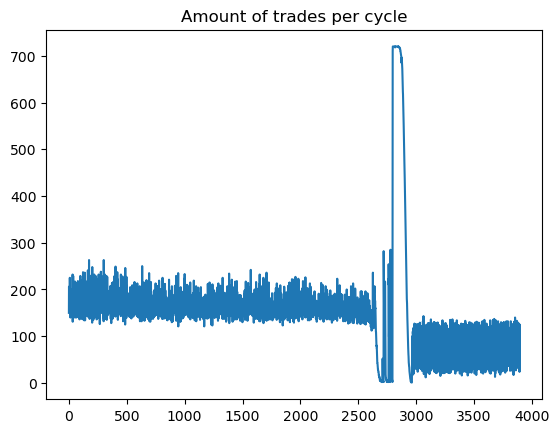

In [23]:
plt.plot(list(range(len(ob.trade_counts))), ob.trade_counts, label = '#Trades')
plt.title('Amount of trades per cycle')
plt.show()

In [26]:
num =0
for agent_id in ob.agents_dict:
    print(ob.agents_dict[agent_id][2])
    num +=1
print(num)

159737.6320876358
172589.97070475548
194798.95170920534
178665.46262960008
184636.0739167185
175315.7517324894
173411.43731555197
176218.5223542308
171799.38782467454
180578.97714849893
172931.63646570448
184575.83155865004
176029.09049144096
186693.61646375095
176458.91504729367
179818.55793593245
178659.02662395974
190069.06492507397
183273.55430893094
172830.91207474543
193059.0811563966
188932.5425305417
179984.34127580366
184251.0201950997
178507.614083104
174437.3856753464
176310.33474522247
178525.12140466506
165772.90244925994
177730.295912106
189488.53613378914
181542.62151501674
189869.67643844782
175961.45851445972
179076.94446256338
172660.30942797405
172331.4373152952
171574.71848626435
187216.45432659113
173147.81737346938
186323.17138990562
177496.60909960058
181504.2298986563
182129.7810740813
189380.07007331104
179950.61291686547
175660.18924348464
184129.66163521822
177431.4072265877
192698.37415931554
175426.607955142
180069.52516705525
179709.87802239956
184896.1472

In [25]:
money = []
zeros = 0
for agent_id in ob.agents_dict:
    money.append(ob.agents_dict[agent_id][2])
    if ob.agents_dict[agent_id][3] == 0:
        print(ob.agents_dict[agent_id][0])
        zeros += 1
print(zeros)


chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
chart
char

Text(0, 0.5, 'Price')

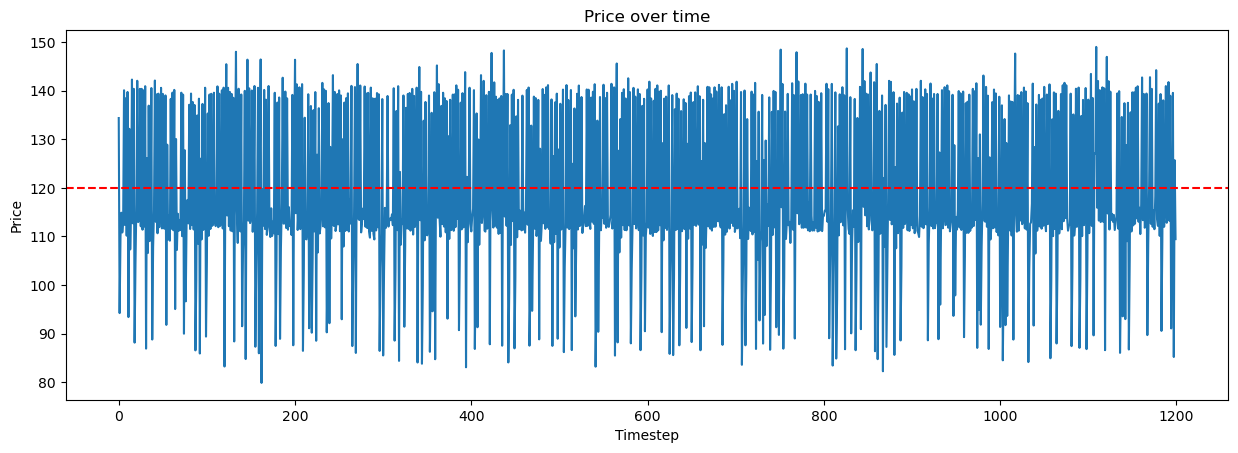

In [27]:
plt.figure().set_figwidth(15)
plt.plot(list(range(len(asset_prices[:1200]))), asset_prices[:1200], label ='asset price')
plt.axhline(y=120, color='r', linestyle='--', label='fundamental price 120')
plt.title("Price over time")
plt.xlabel("Timestep")
plt.ylabel("Price")

In [28]:
print(len(asset_prices))

10000


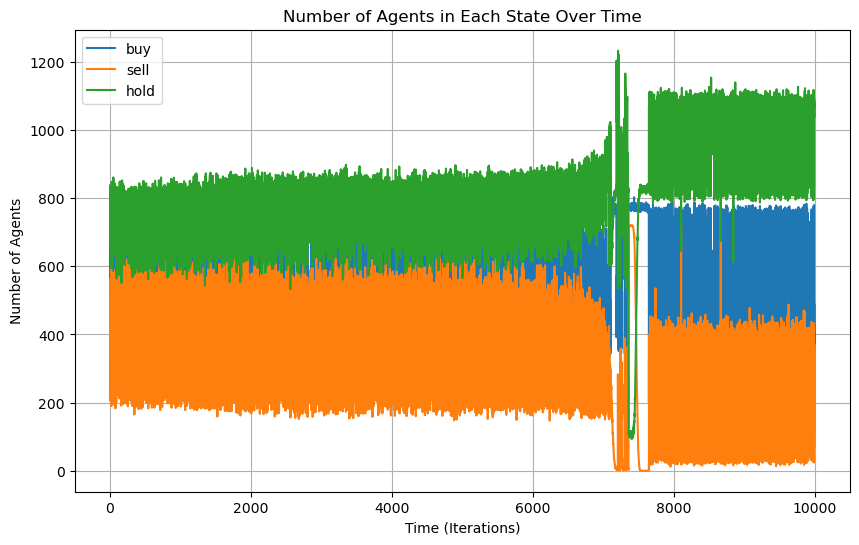

In [29]:
# After the simulation ends, create a chart to show the number of agents in each state over time
plt.figure(figsize=(10, 6))
for state, counts in ob.state_counts.items():
    plt.plot(range(len(counts)), counts, label=state)
# plt.plot(range(len(ob.info_counts)), ob.info_counts, label='info > 1')  # Plot the count of agents with info > 1
plt.xlabel('Time (Iterations)')
plt.ylabel('Number of Agents')
plt.title('Number of Agents in Each State Over Time')
plt.legend()
plt.grid(True)
plt.savefig("soc_network.png")
plt.show()

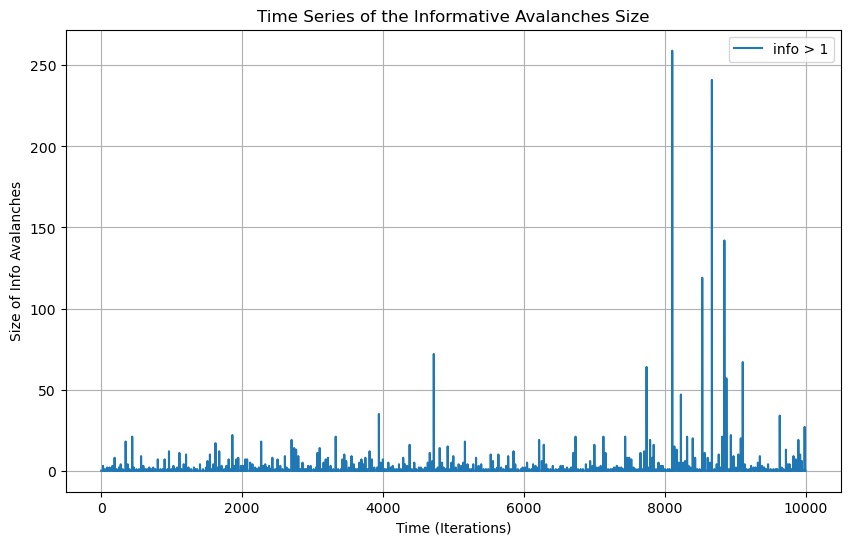

In [30]:
# After the simulation ends, create a chart to show the number of agents in each state over time
plt.figure(figsize=(10, 6))
# for state, counts in ob.state_counts.items():
#     plt.plot(range(len(counts)), counts, label=state)
plt.plot(range(len(ob.info_counts)), ob.info_counts, label='info > 1')  # Plot the count of agents with info > 1
plt.xlabel('Time (Iterations)')
plt.ylabel('Size of Info Avalanches')
plt.title('Time Series of the Informative Avalanches Size')
plt.legend()
plt.grid(True)
plt.savefig("soc_network.png")
plt.show()

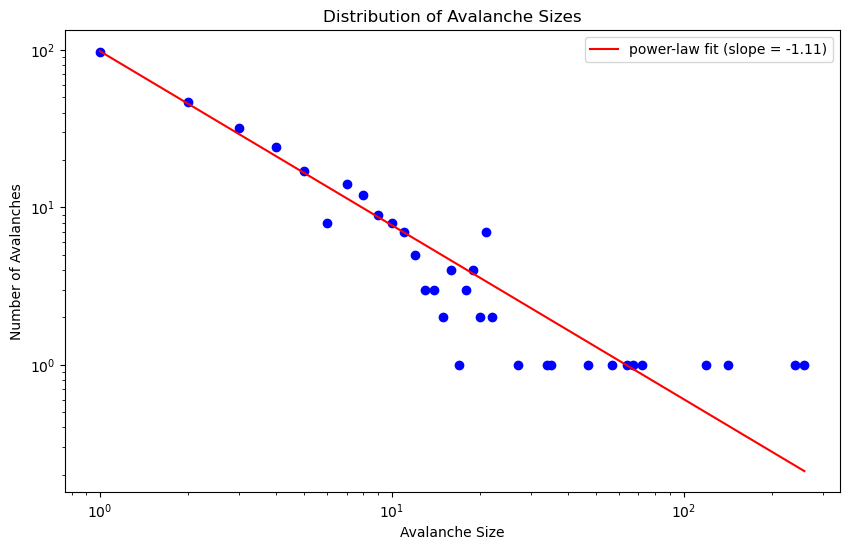

In [31]:
# Filter out the time steps where no avalanche occurred
avalanche_sizes = np.array(ob.info_counts)
avalanche_sizes = avalanche_sizes[avalanche_sizes > 0]

# Calculate the unique avalanche sizes and their counts
avalanche_sizes, counts = np.unique(avalanche_sizes, return_counts=True)

# Define the power-law function for fitting
def power_law(x, a, b):
    return a * np.power(x, b)

# Fit the power-law curve to the data
params, _ = curve_fit(power_law, avalanche_sizes, counts)

# Unpack fitting parameters for plotting
a, b = params

plt.figure(figsize=(10, 6))
plt.scatter(avalanche_sizes, counts, color='blue')  # Scatter plot of the raw data

# Generate points for the fitted line
fitted_line = power_law(avalanche_sizes, a, b)

# Plot the fitted line
plt.plot(avalanche_sizes, fitted_line, label=f'power-law fit (slope = {b:.2f})', color='red')

# Set the plot to log-log scale
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Avalanche Size')
plt.ylabel('Number of Avalanches')
plt.title('Distribution of Avalanche Sizes')

plt.legend()
plt.show()

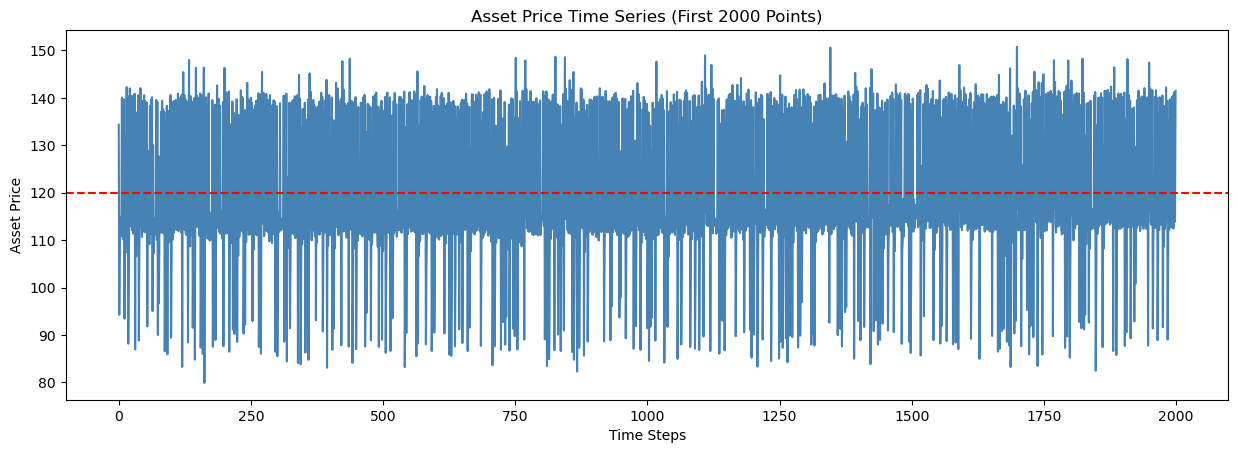

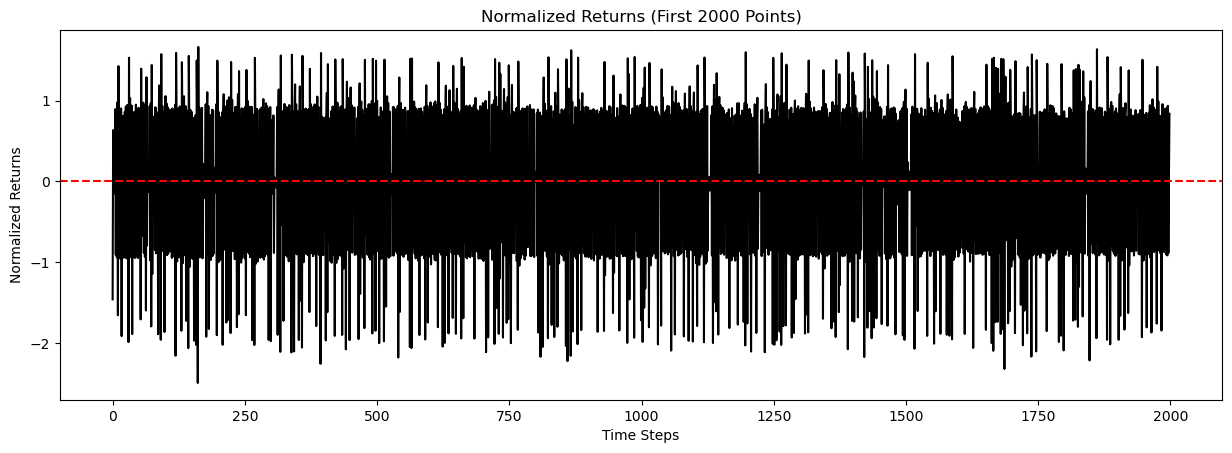

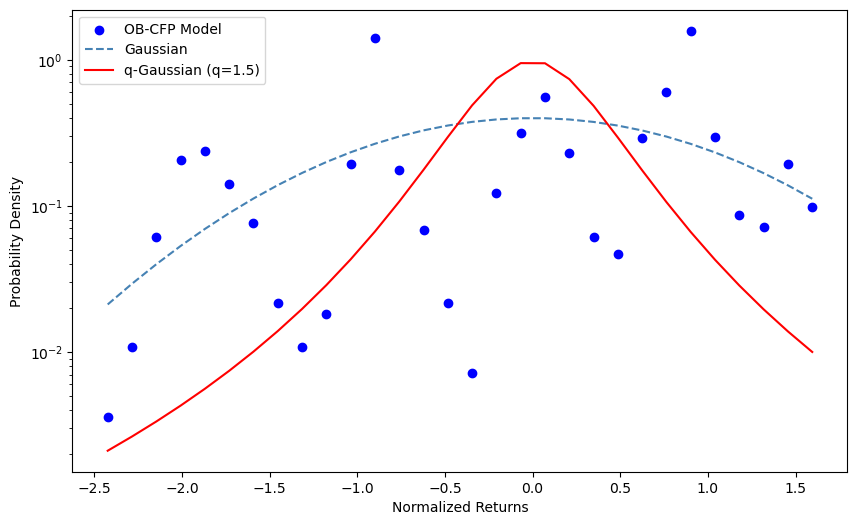

In [34]:
# Use the first 2000 data points
asset_prices_subset = asset_prices[:2000]

# Calculate returns rt
rt = np.log(asset_prices_subset[1:]) - np.log(asset_prices_subset[:-1])

# Calculate average return and standard deviation
r_avg = np.mean(rt)
r_stdev = np.std(rt)

# Calculate normalized returns r^NORM
r_norm = (rt - r_avg) / r_stdev

# Plot the asset price time series
plt.figure().set_figwidth(15)
plt.plot(asset_prices_subset, color='steelblue')
plt.axhline(y=120, color='r', linestyle='--')
plt.title('Asset Price Time Series (First 2000 Points)')
plt.xlabel('Time Steps')
plt.ylabel('Asset Price')
plt.show()

# Plot the normalized returns time series
plt.figure().set_figwidth(15)
plt.plot(r_norm, color='black')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Normalized Returns (First 2000 Points)')
plt.xlabel('Time Steps')
plt.ylabel('Normalized Returns')
plt.show()

# Calculate the probability density function (PDF) of the normalized returns
counts, bin_edges = np.histogram(r_norm, bins=30, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
# Plot the PDF of the normalized returns
plt.figure(figsize=(10, 6))
plt.scatter(bin_centers, counts, label='OB-CFP Model', color='blue')

# Fit a Gaussian distribution
params_norm = norm.fit(r_norm)
pdf_gaussian = norm.pdf(bin_centers, *params_norm)
plt.plot(bin_centers, pdf_gaussian, label='Gaussian', linestyle='--', color='steelblue')

# Definition of the q-Gaussian function
def q_gaussian(x, A, B, q):
    return A * np.power(1 - (1 - q) * B * x**2, 1 / (1 - q))

# Parameters for the q-Gaussian
A = 0.98
B = 7
q = 1.5

# Plot the q-Gaussian
plt.plot(bin_centers, q_gaussian(bin_centers, A, B, q), label='q-Gaussian (q=1.5)', color='red')

plt.yscale('log')
plt.xlabel('Normalized Returns')
plt.ylabel('Probability Density')
plt.legend()
plt.show()